In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

In [2]:
df = pd.read_csv('upPackets.csv', sep= ";")

In [3]:
df.head()

,id,gwui,time,tmms,tmst,freq,chan,rfch,stat,modu,datr,codr,rssi,lsnr,size,data
0,33,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,SF7BW125,4/5,-100,2.8,9,CieFBjcaAv4B
1,34,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,SF7BW125,4/5,-99,4.0,9,CieFBjcaAv4B
2,35,AC1F09FFFE057698,Nan,Nan,1729188407,868.3,1,1,1,LORA,SF7BW125,4/5,-104,2.3,8,C8bTDAVZBQA=
3,36,AC1F09FFFE057698,Nan,Nan,1729188407,868.3,1,1,1,LORA,SF7BW125,4/5,-104,0.5,9,C8bTDAVZAv4B
4,37,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,SF7BW125,4/5,-111,1.5,8,CyCSDMkzAQA=


In [4]:
df.shape

(5895982, 16)

### Decoding Data Column

In [5]:
import base64
from pprint import pprint

def decode_lorawan_packet(base64_packet):
    try:
        # Decode the base64 packet into bytes
        packet_bytes = base64.b64decode(base64_packet)

        # Initialize an empty dictionary to store packet components
        packet_dict = {}

        # Extracting the MHDR (Message Header)
        packet_dict['MHDR'] = packet_bytes[0]
        packet_dict['MType'] = (packet_bytes[0] >> 5) & 0x07
        packet_dict['RFU'] = (packet_bytes[0] >> 2) & 0x07
        packet_dict['Major'] = packet_bytes[0] & 0x03

        # Extract DevAddr (4 bytes, little-endian)
        devaddr_bytes = packet_bytes[1:5]
        packet_dict['DevAddr'] = devaddr_bytes[::-1].hex()

        # FCtrl (Frame Control)
        packet_dict['FCtrl'] = packet_bytes[5]

        # FCnt (Frame Counter, 2 bytes, little-endian)
        fcnt_bytes = packet_bytes[6:8]
        packet_dict['FCnt'] = int.from_bytes(fcnt_bytes, byteorder='little')

        # Optional FOpts (Frame Options), its length depends on the lower 4 bits of FCtrl
        fopts_length = packet_dict['FCtrl'] & 0x0F
        fopts_end = 8 + fopts_length
        packet_dict['FOpts'] = packet_bytes[8:fopts_end].hex() if fopts_length > 0 else None

        # FPort (1 byte after FOpts, if present)
        if len(packet_bytes) > fopts_end:
            packet_dict['FPort'] = packet_bytes[fopts_end]
            fopts_end += 1
        else:
            packet_dict['FPort'] = None

        # FRMPayload (remaining bytes after FPort)
        if len(packet_bytes) > fopts_end:
            packet_dict['FRMPayload'] = packet_bytes[fopts_end:].hex()
        else:
            packet_dict['FRMPayload'] = None

        return packet_dict
    except:
        return None

In [6]:
decoded_df = df["data"].apply(decode_lorawan_packet).apply(pd.Series)

df = pd.concat([df.drop(columns=["data"]), decoded_df], axis=1)

In [7]:
df.head()

,id,gwui,time,tmms,tmst,freq,chan,rfch,stat,modu,...,MHDR,MType,RFU,Major,DevAddr,FCtrl,FCnt,FOpts,FPort,FRMPayload
0,33,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,...,10.0,0.0,2.0,2.0,37068527,26.0,65026.0,01,NaN,None
1,34,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,...,10.0,0.0,2.0,2.0,37068527,26.0,65026.0,01,NaN,None
2,35,AC1F09FFFE057698,Nan,Nan,1729188407,868.3,1,1,1,LORA,...,11.0,0.0,2.0,3.0,050cd3c6,89.0,5.0,,NaN,None
3,36,AC1F09FFFE057698,Nan,Nan,1729188407,868.3,1,1,1,LORA,...,11.0,0.0,2.0,3.0,050cd3c6,89.0,65026.0,01,NaN,None
4,37,AC1F09FFFE057698,Nan,Nan,1729188407,868.1,0,1,1,LORA,...,11.0,0.0,2.0,3.0,c90c9220,51.0,1.0,,NaN,None


In [8]:
df.columns

Index(['id', 'gwui', 'time', 'tmms', 'tmst', 'freq', 'chan', 'rfch', 'stat',
       'modu', 'datr', 'codr', 'rssi', 'lsnr', 'size', 'MHDR', 'MType', 'RFU',
       'Major', 'DevAddr', 'FCtrl', 'FCnt', 'FOpts', 'FPort', 'FRMPayload'],
      dtype='object')

In [9]:
df.shape

(5895982, 25)

In [10]:
df.duplicated().sum() #No duplicate rows

0

In [11]:
df["gwui"].nunique() # Only one gateway

2

Number of packets per gateway:
gwui
AC1F09FFFE057698    5895979
1CD868E17E4DB54C          3
Name: count, dtype: int64


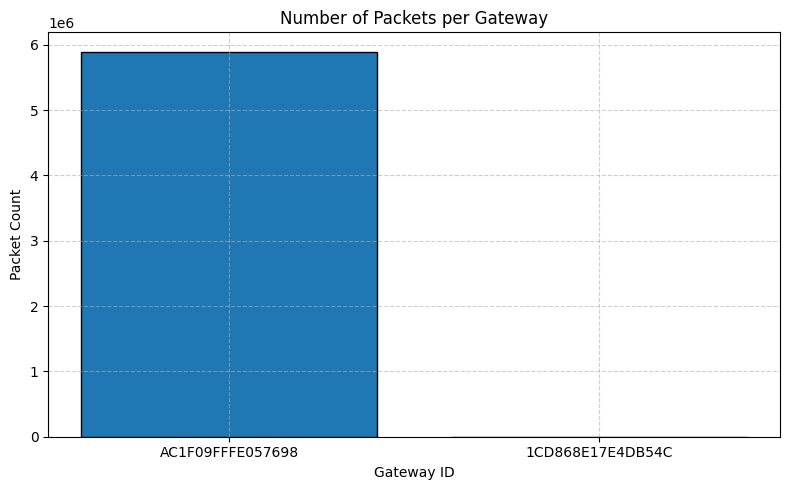

In [ ]:
# Count packets received by each gateway
gateway_counts = df['gwui'].value_counts()

print("Number of packets per gateway:")
print(gateway_counts)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(gateway_counts.index.astype(str), gateway_counts.values, edgecolor='black')
plt.title('Number of Packets per Gateway')
plt.xlabel('Gateway ID')
plt.ylabel('Packet Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [16]:
df = df[df['gwui'] == 'AC1F09FFFE057698']

In [17]:
len(df["DevAddr"].unique()) #5364 end devices

166983

In [18]:
# Show count of NaNs per column
nan_counts = df.isna().sum()

# Display only columns with at least one NaN
print(nan_counts[nan_counts > 0])

MHDR               69
MType              69
RFU                69
Major              69
DevAddr            69
FCtrl              69
FCnt               69
FOpts         2304641
FPort         3081006
FRMPayload    3093266
dtype: int64


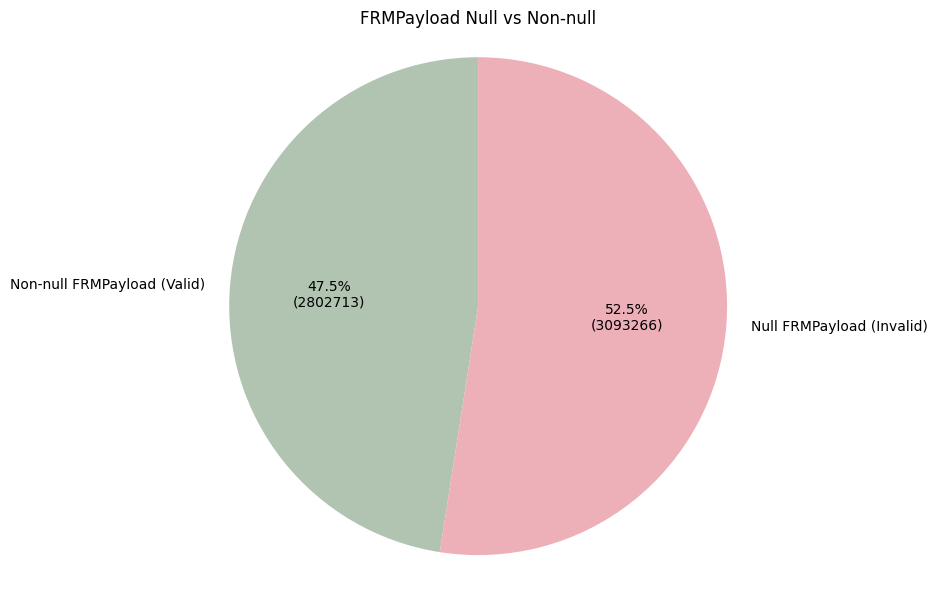

In [19]:
# Count null and non-null values
null_count = df['FRMPayload'].isnull().sum()
non_null_count = df['FRMPayload'].notnull().sum()

labels = ['Non-null FRMPayload (Valid)', 'Null FRMPayload (Invalid)']
values = [non_null_count, null_count]
colors = [ '#b0c4b1', '#edafb8']

# Custom function to show both count and percentage
def autopct_format(pct, all_vals):
    absolute = int(round(pct/100. * sum(all_vals)))
    return f"{pct:.1f}%\n({absolute})"

# Plot
plt.figure(figsize=(10, 6))
plt.pie(
    values,
    labels=labels,
    colors=colors,
    autopct=lambda pct: autopct_format(pct, values),
    startangle=90
)
plt.title("FRMPayload Null vs Non-null")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [20]:
df_null_frmpayload = df[df['FRMPayload'].isnull()]
df_valid_packets = df[df['FRMPayload'].notnull()]

### FPort Analysis

In [21]:
df_valid_packets["FPort"].unique()

array([ 64.,  10.,   0.,   1.,   2.,   3.,  17.,  31., 111.,   5.,  13.,
       167.,  77., 224., 120.,  46.,  78., 123., 237., 255.,   9.,  15.,
        85.,  34.,  97., 216.,  44.,  23., 110., 171., 144., 155., 180.,
       248., 100.,  25., 141., 235., 254., 159., 187., 106.,  68.,  18.,
       189.,  32.,  35.,  12., 211.,  62.,   4.,  22., 172., 164.,  36.,
        61., 124.,  93.,  59.,  90., 219.,  55., 150., 188., 161., 143.,
        38., 197.,  43., 206.,  27., 223.,  19., 182., 101., 184., 168.,
        83., 162.,  74.,  21., 163.,   8., 166.,  92.,  63.,  47., 126.,
       210., 113., 245.,  87., 201.,  11., 152., 112., 234., 247., 146.,
        20., 154., 135., 131., 102., 251., 132.,  99.,  26.,  71., 198.,
       226.,  89.,   6.,  79.,  48., 240.,  65., 253., 169.,  67., 128.,
       246., 139.,  69., 222., 174.,  29.,  49., 252., 200., 138., 205.,
        88.,  24.,  41., 195., 242., 203.,  70., 190., 125., 175., 103.,
       177., 145.,  51.,  95.,  53., 127., 109., 10

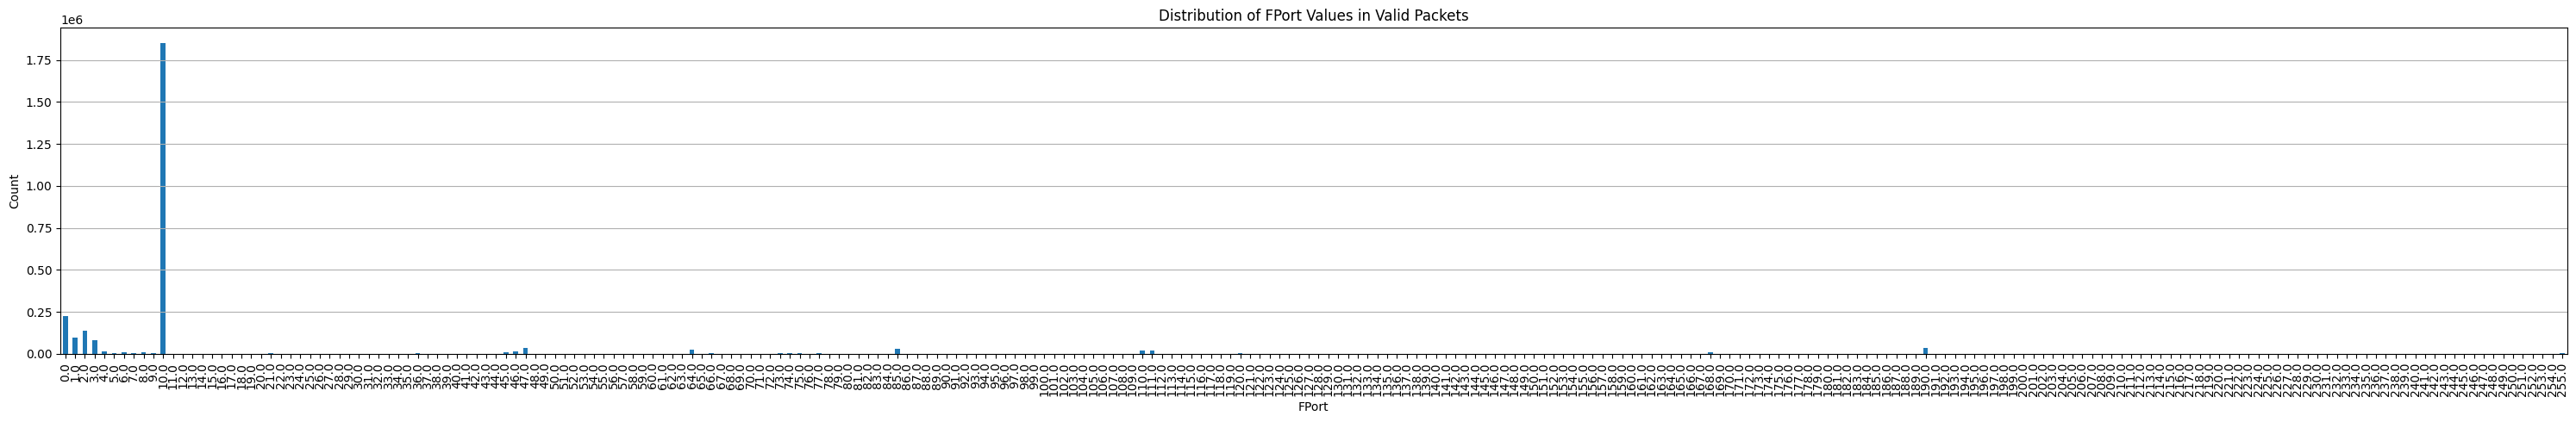

In [22]:
# Create a histogram (bar chart) of the FPort column
fport_counts = df_valid_packets["FPort"].value_counts().sort_index()

plt.figure(figsize=(30, 5))
fport_counts.plot(kind='bar')
plt.xlabel("FPort")
plt.ylabel("Count")
plt.title("Distribution of FPort Values in Valid Packets")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [23]:
# Count FPort occurrences
fport_counts = df_valid_packets["FPort"].value_counts()

# Identify FPorts in the 244–255 range (Special Use)
special_use_fports = fport_counts[fport_counts.index >= 244]
special_use_sum = special_use_fports.sum()

# Remove special use FPorts from the main counts temporarily
fport_counts_cleaned = fport_counts.drop(special_use_fports.index, errors='ignore')

# Get the top 6 FPorts from the cleaned counts
top_6 = fport_counts_cleaned.head(6)

# Remove those top 6 from cleaned to find the rest (Others)
remaining_fports = fport_counts_cleaned.drop(top_6.index, errors='ignore')
others_sum = remaining_fports.sum()

# Combine all into final Series
final_series = pd.concat([
    top_6,
    pd.Series({'Special Use': special_use_sum}),
    pd.Series({'Others': others_sum})
])

# Convert to lists
labels = final_series.index.tolist()
values = final_series.values.tolist()

# Plot
fig = go.Figure(data=[
    go.Pie(labels=labels, values=values, pull=[0, 0.2, 0, 0, 0, 0, 0, 0], textinfo='label+percent')
])

fig.update_layout(
    title=dict(
        text="FPort Distribution for Valid Packets",
        font=dict(size=24),
        x=0.5,
        xanchor='center'
    ),
    legend_title="FPorts",
    legend=dict(font=dict(size=14)),
    width=800,
    height=600
)

fig.show()

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/1627989326.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



FPort_category
Application    2559761
Control         223668
Reserved         19284
Name: count, dtype: int64


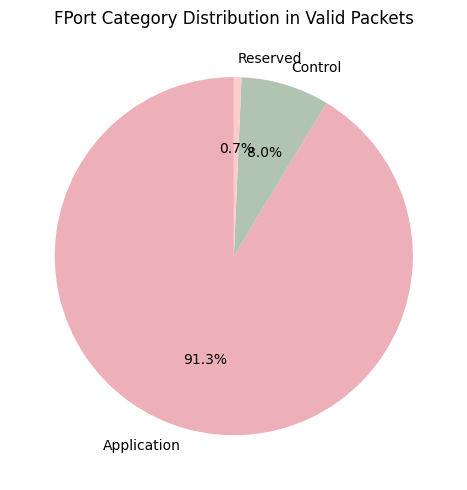

In [24]:
# Filter only packets with valid payload
valid_packets = df[df['FRMPayload'].notnull()]

# Function to categorize FPort values
def categorize_fport(fport):
    if fport == 0:
        return 'Control'
    elif 1 <= fport <= 223:
        return 'Application'
    elif 224 <= fport <= 255:
        return 'Reserved'
    else:
        return 'Unknown'

# Apply categorization to create a new column
valid_packets['FPort_category'] = valid_packets['FPort'].apply(categorize_fport)

# Count the number of packets in each category
category_counts = valid_packets['FPort_category'].value_counts()

print(category_counts)

# Optional: Plot the distribution as a pie chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#edafb8', '#b0c4b1', '#ffcccb'])
plt.title('FPort Category Distribution in Valid Packets')
plt.ylabel('')  # Remove the default label
plt.tight_layout()
plt.show()


In [25]:
# Count FPort occurrences
fport_counts_invalid = df_null_frmpayload["FPort"].value_counts()

# Identify FPorts in the 244–255 range (Special Use)
special_use_fports_invalid = fport_counts_invalid[fport_counts.index >= 244]
special_use_sum_invalid = special_use_fports.sum()

# Remove special use FPorts from the main counts temporarily
fport_counts_cleaned_invalid = fport_counts_invalid.drop(special_use_fports_invalid.index, errors='ignore')

# Get the top 6 FPorts from the cleaned counts
top_6 = fport_counts_cleaned_invalid.head(6)

# Remove those top 6 from cleaned to find the rest (Others)
remaining_fports_invalid = fport_counts_cleaned_invalid.drop(top_6.index, errors='ignore')
others_sum_invalid = remaining_fports_invalid.sum()

# Combine all into final Series
final_series_invalid = pd.concat([
    top_6,
    pd.Series({'Special Use': special_use_sum_invalid}),
    pd.Series({'Others': others_sum_invalid})
])

# Convert to lists
labels_invalid = final_series_invalid.index.tolist()
values_invalid = final_series_invalid.values.tolist()

# Plot
fig = go.Figure(data=[
    go.Pie(labels=labels_invalid, values=values_invalid, pull=[0, 0.2, 0, 0, 0, 0, 0, 0], textinfo='label+percent')
])

fig.update_layout(
    title=dict(
        text="FPort Distribution for Invalid Packets",
        font=dict(size=24),
        x=0.5,
        xanchor='center'
    ),
    legend_title="FPorts",
    legend=dict(font=dict(size=14)),
    width=800,
    height=600
)

fig.show()

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/1281704917.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



FPort_category
Unknown        3081006
Control           7136
Application       4804
Reserved           320
Name: count, dtype: int64


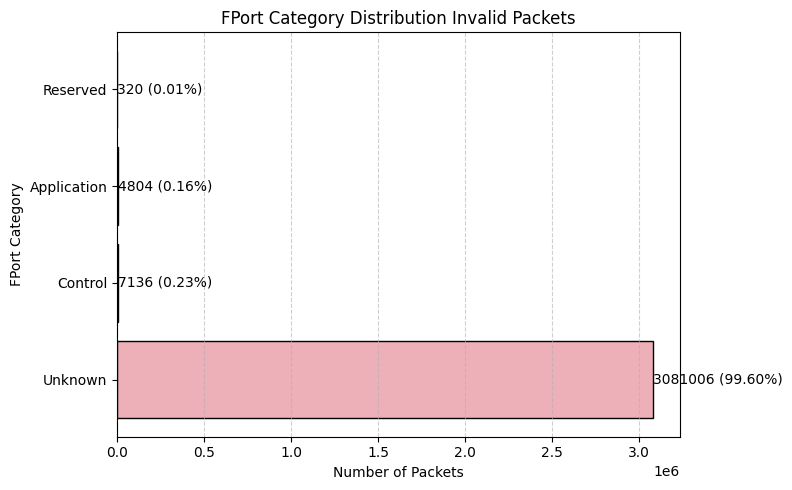

In [88]:
# Filter only packets with invalid payload
invalid_packets = df[df['FRMPayload'].notnull()==False]

# Function to categorize FPort values
def categorize_fport(fport):
    if fport == 0:
        return 'Control'
    elif 1 <= fport <= 223:
        return 'Application'
    elif 224 <= fport <= 255:
        return 'Reserved'
    else:
        return 'Unknown'

# Apply categorization to create a new column
invalid_packets['FPort_category'] = invalid_packets['FPort'].apply(categorize_fport)

# Count the number of packets in each category
category_counts = invalid_packets['FPort_category'].value_counts()

print(category_counts)

# Reorder for consistent colors
category_counts = category_counts.reindex(['Unknown', 'Control', 'Application', 'Reserved'])
colors = ['#edafb8', '#b0c4b1', '#ffcccb', '#d3d3d3']

# Plot as horizontal bars
plt.figure(figsize=(8, 5))
bars = plt.barh(category_counts.index, category_counts.values, color=colors, edgecolor='black')

# Add percentage annotations to bars
total_packets = category_counts.sum()
for bar, count in zip(bars, category_counts.values):
    percentage = (count / total_packets) * 100
    plt.text(count + 100, bar.get_y() + bar.get_height()/2,
             f'{count} ({percentage:.2f}%)',
             va='center', fontsize=10)

plt.title('FPort Category Distribution Invalid Packets')
plt.xlabel('Number of Packets')
plt.ylabel('FPort Category')
plt.grid(True, linestyle='--', alpha=0.6, axis='x')
plt.tight_layout()
plt.show()


### Device Count by Number of Packets Sent

Maximum number of packets sent by a device: 99371


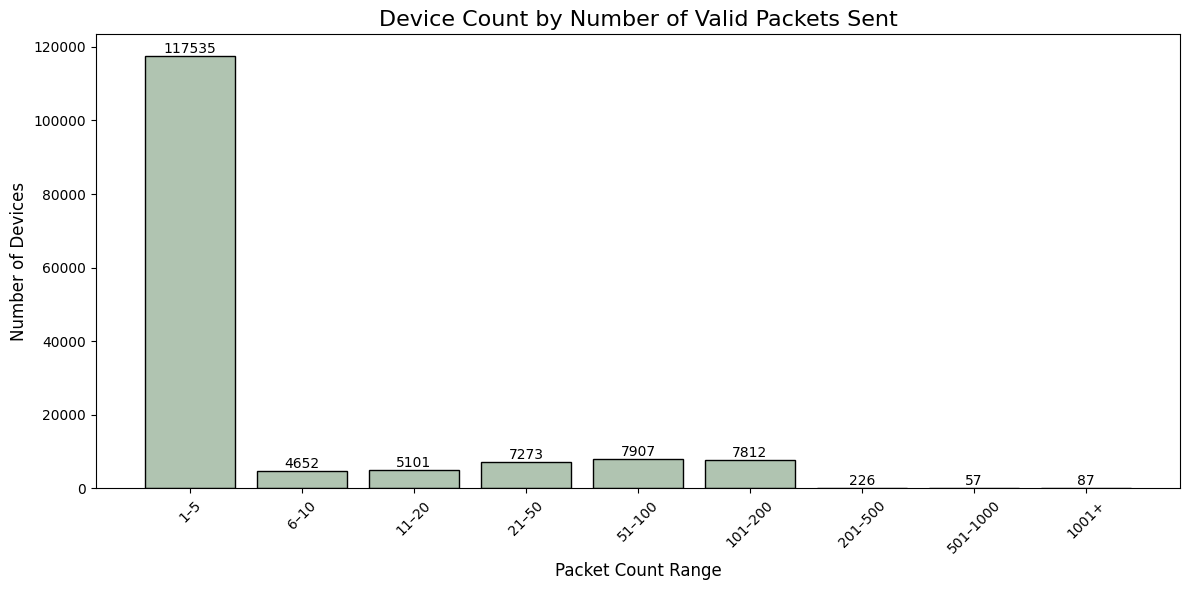

In [27]:
# Count how many packets per DevAddr
devaddr_counts = df_valid_packets['DevAddr'].value_counts()
print("Maximum number of packets sent by a device:", devaddr_counts.max())
# Define bins and labels
bins = [1, 6, 11, 21, 51, 101, 201, 501, 1001, float('inf')]
labels = ['1–5', '6–10', '11–20', '21–50', '51–100', '101–200', '201–500', '501–1000', '1001+']

# Bin the device packet counts
binned = pd.cut(devaddr_counts, bins=bins, labels=labels, right=False)
binned_counts = binned.value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(binned_counts.index.astype(str), binned_counts.values, edgecolor='black', color='#b0c4b1')
plt.title('Device Count by Number of Valid Packets Sent', fontsize=16)
plt.xlabel('Packet Count Range', fontsize=12)
plt.ylabel('Number of Devices', fontsize=12)
plt.xticks(rotation=45)

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,
        str(height),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

Maximum number of packets sent by a device: 169259


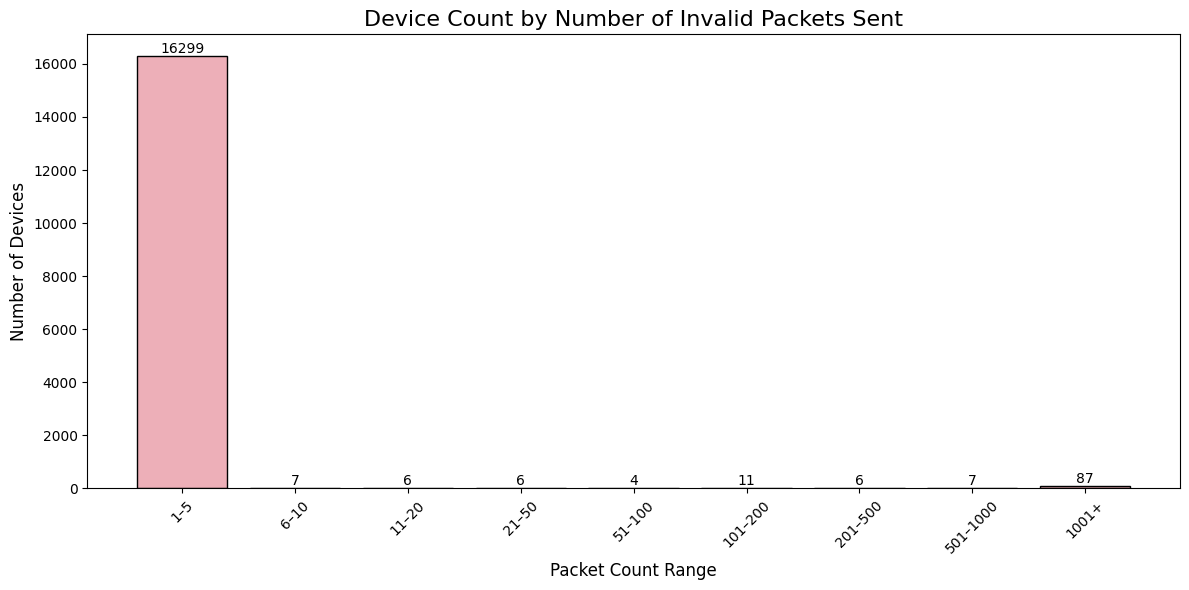

In [28]:
# Count how many packets per DevAddr
devaddr_counts_invalid = df_null_frmpayload['DevAddr'].value_counts()
print("Maximum number of packets sent by a device:", devaddr_counts_invalid.max())

# Define bins and labels
bins = [1, 6, 11, 21, 51, 101, 201, 501, 1001, float('inf')]
labels = ['1–5', '6–10', '11–20', '21–50', '51–100', '101–200', '201–500', '501–1000', '1001+']

# Bin the device packet counts
binned_invalid = pd.cut(devaddr_counts_invalid, bins=bins, labels=labels, right=False)
binned_counts_invalid = binned_invalid.value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
bars_invalid= plt.bar(binned_counts_invalid.index.astype(str), binned_counts_invalid.values, edgecolor='black', color='#edafb8')
plt.title('Device Count by Number of Invalid Packets Sent', fontsize=16)
plt.xlabel('Packet Count Range', fontsize=12)
plt.ylabel('Number of Devices', fontsize=12)
plt.xticks(rotation=45)

# Add labels on top of each bar
for bar in bars_invalid:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,
        str(height),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

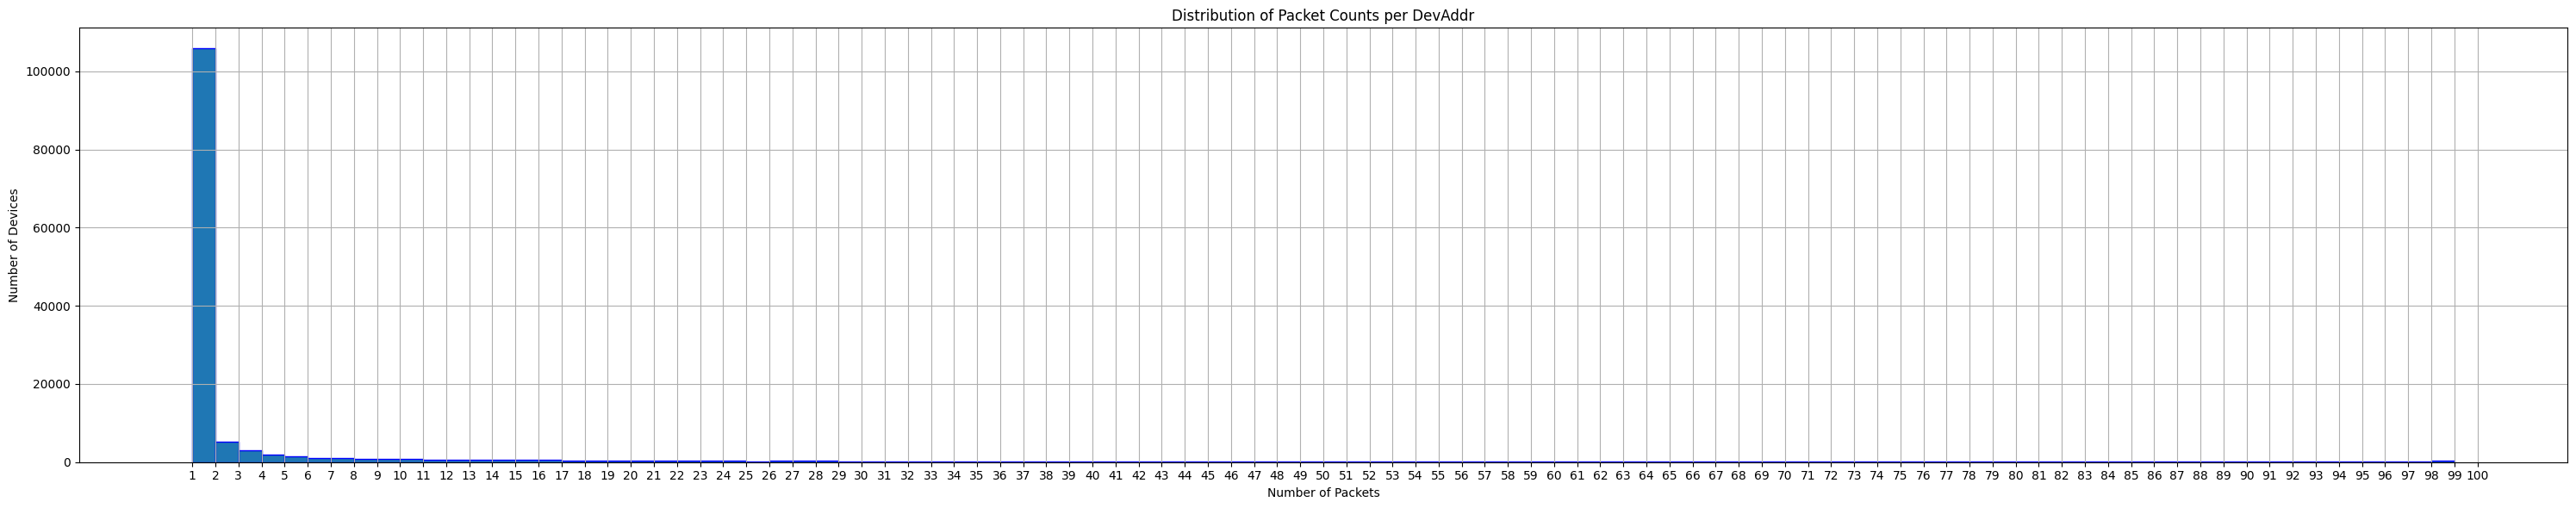

In [29]:
# A close up histogram
plt.figure(figsize=(30, 6))
plt.hist(devaddr_counts, bins=range(1, 100), edgecolor='blue')
plt.title('Distribution of Packet Counts per DevAddr')
plt.xlabel('Number of Packets')
plt.ylabel('Number of Devices')
plt.grid(True)
plt.tight_layout()
plt.xticks(ticks=range(1, 101))
plt.show()

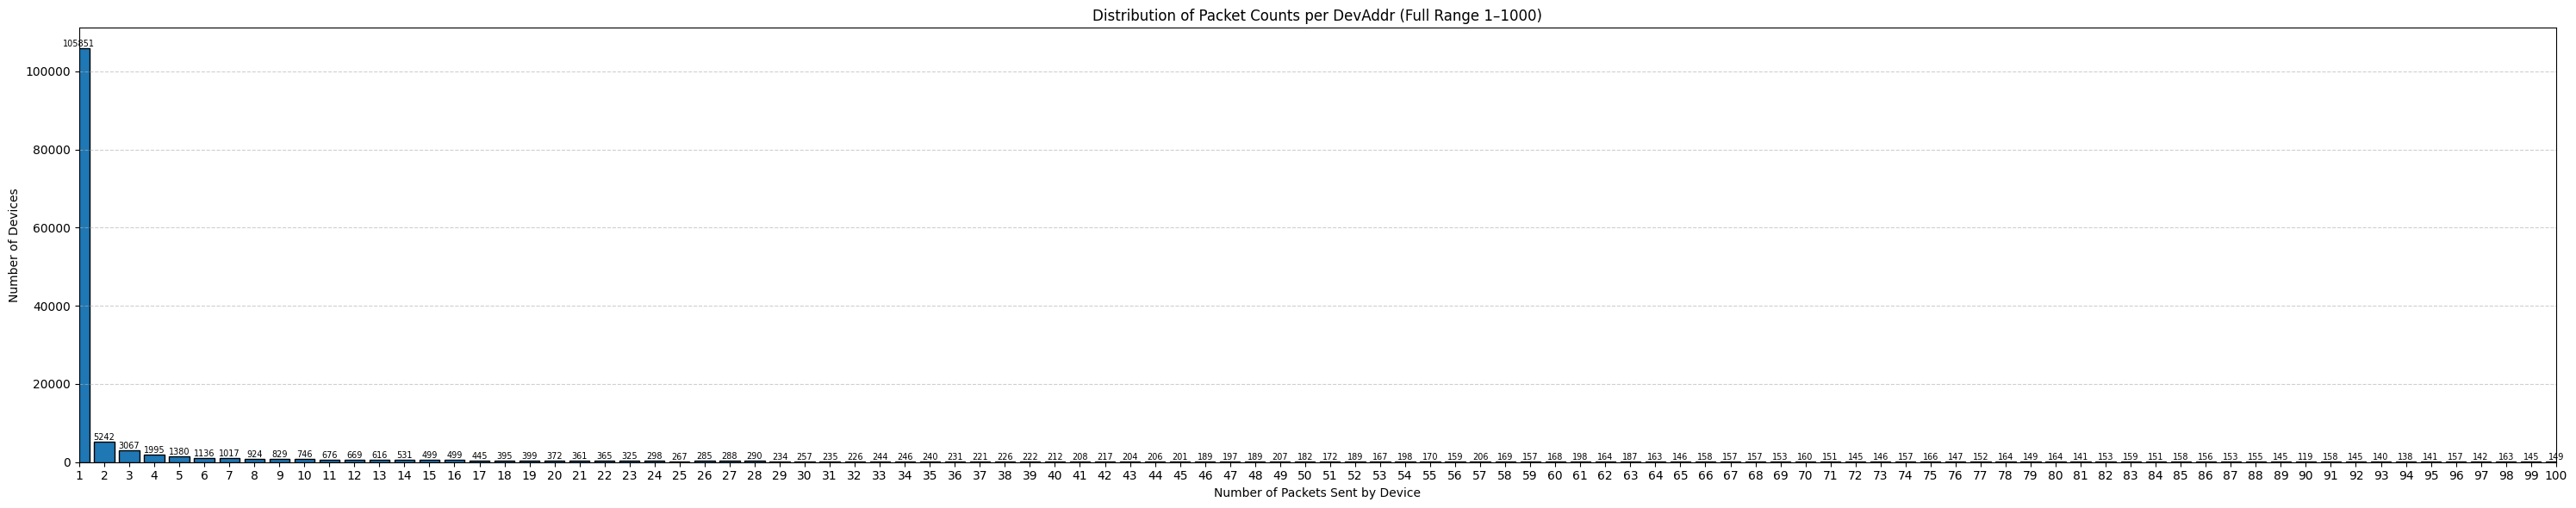

In [30]:
# Count how many devices sent X packets
packet_distribution = devaddr_counts.value_counts().sort_index()

# Ensure full x-axis from 1 to 1000
full_range = pd.Series(index=range(1, 101), dtype=int)
packet_distribution = packet_distribution.reindex(full_range.index, fill_value=0)

# Plot bar chart
plt.figure(figsize=(30, 6))
bars = plt.bar(packet_distribution.index, packet_distribution.values, edgecolor='black')

# Optionally add labels (skip if too crowded)
for bar in bars:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)),
  ha='center', va='bottom', fontsize=7)

plt.title('Distribution of Packet Counts per DevAddr (Full Range 1–1000)')
plt.xlabel('Number of Packets Sent by Device')
plt.ylabel('Number of Devices')
plt.xlim(1, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.xticks(ticks=range(1, 101))
plt.show()

# RSSI Histogram


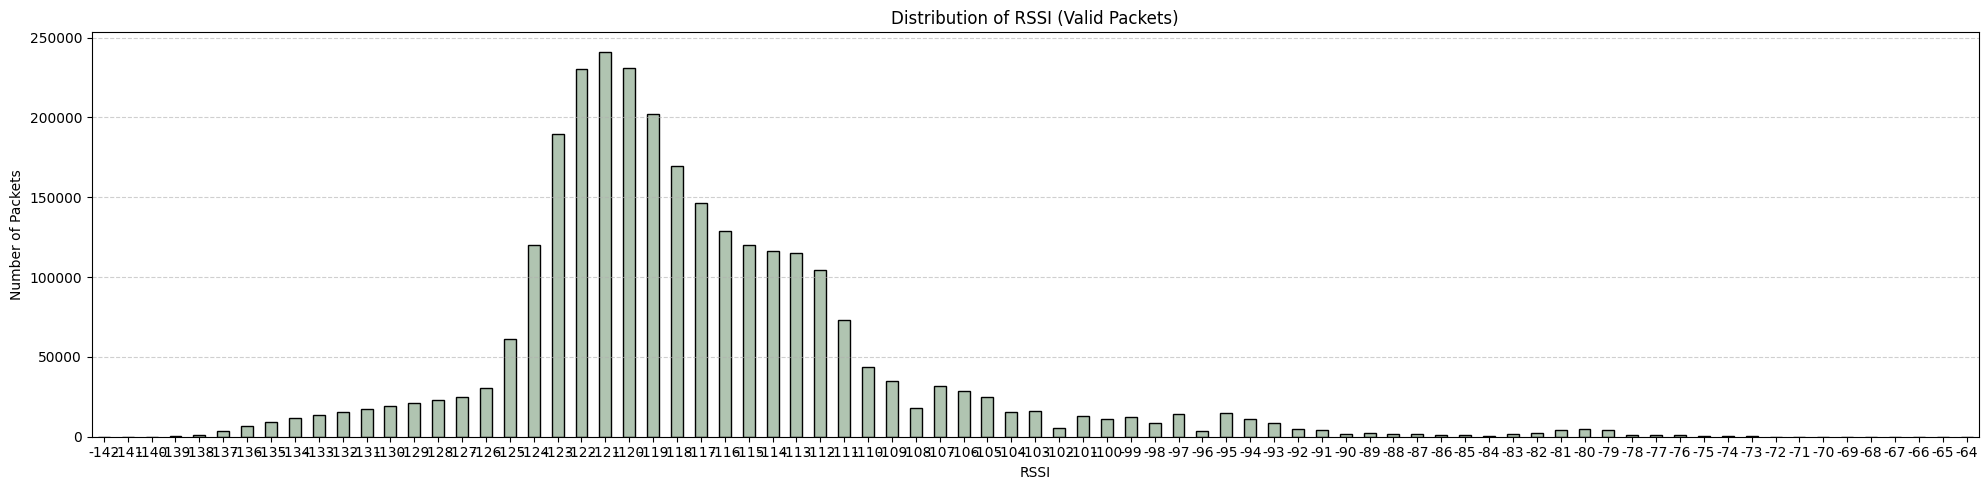

In [31]:
# Count and sort rssi values
rssi_counts = df_valid_packets['rssi'].value_counts().sort_index()

plt.figure(figsize=(20, 5))
rssi_counts.plot(kind='bar', color='#b0c4b1',  edgecolor='black')
plt.title('Distribution of RSSI (Valid Packets)')
plt.xlabel('RSSI')
plt.ylabel('Number of Packets')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

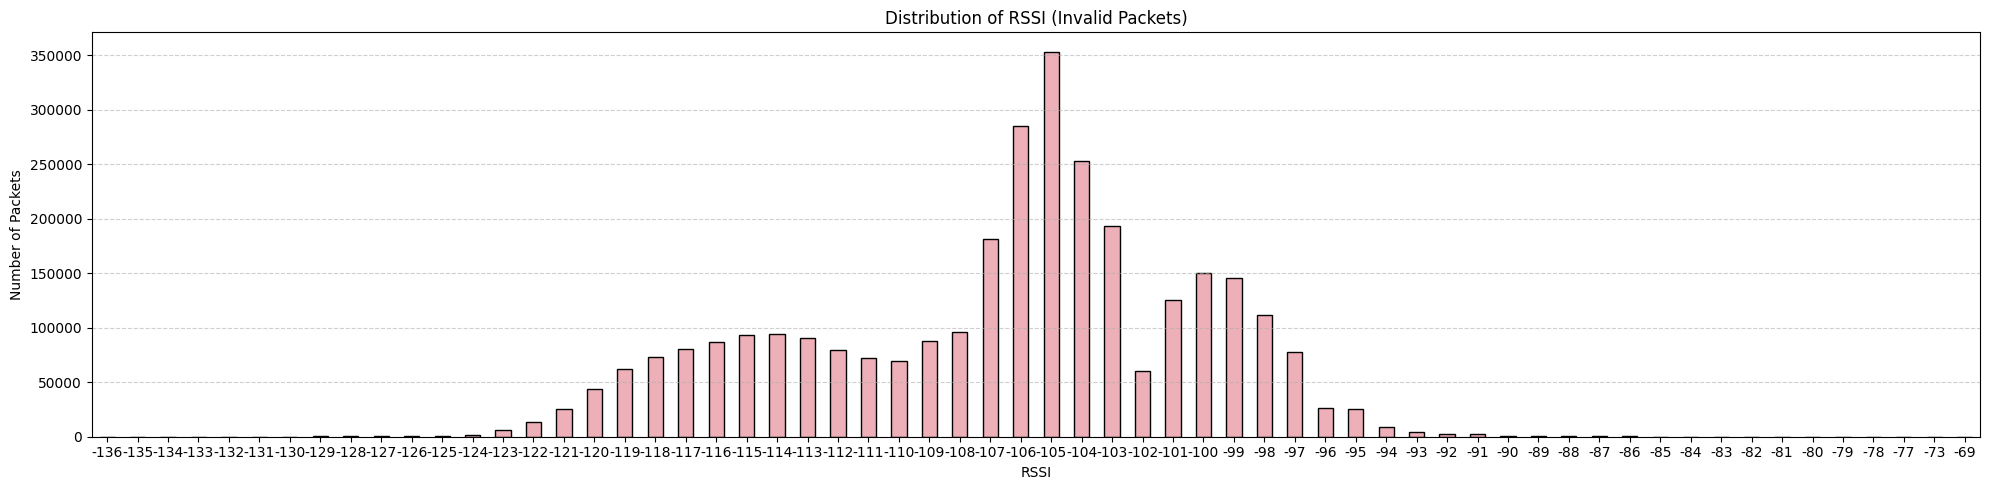

In [32]:
# Count and sort rssi values
rssi_counts_invalid = df_null_frmpayload['rssi'].value_counts().sort_index()

plt.figure(figsize=(20, 5))
rssi_counts_invalid.plot(kind='bar', color='#edafb8', edgecolor='black')
plt.title('Distribution of RSSI (Invalid Packets)')
plt.xlabel('RSSI')
plt.ylabel('Number of Packets')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### SF Histogram

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/2421202418.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



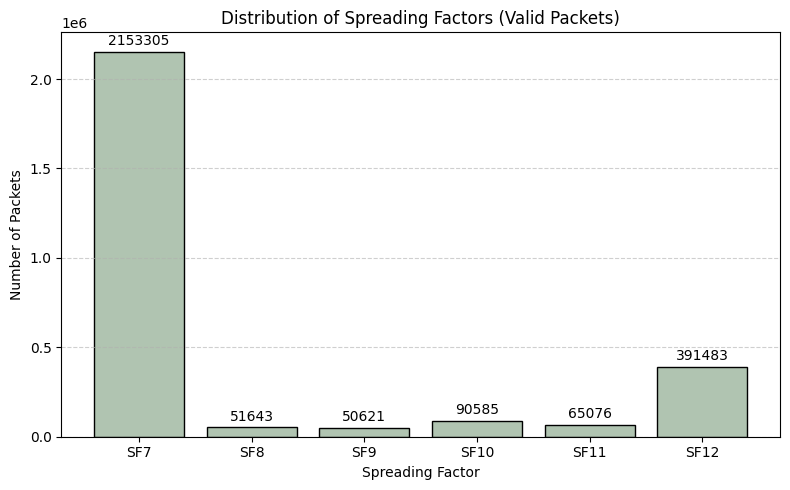

In [33]:
# Extract numeric SF
df_valid_packets['sf_num'] = df_valid_packets['datr'].str.extract(r'SF(\d+)')[0].astype(float)

# Count, sort numerically, and relabel
sf_counts_valid = df_valid_packets['sf_num'].value_counts().sort_index()
sf_labels = [f'SF{int(sf)}' for sf in sf_counts_valid.index]  # relabel x-axis

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(sf_labels, sf_counts_valid.values, color='#b0c4b1', edgecolor='black')
plt.title('Distribution of Spreading Factors (Valid Packets)')
plt.xlabel('Spreading Factor')
plt.ylabel('Number of Packets')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(sf_counts_valid.values) * 0.01,  # Slight vertical offset
        str(int(height)),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()


In [74]:
# Filter for high spreading factors
high_sf = [12, 11]
df_high_sf = df_valid_packets[df_valid_packets['sf_num'].isin(high_sf)]

# Count high SF packets per device (DevAddr)
device_high_sf_counts = df_high_sf['DevAddr'].value_counts().reset_index()
device_high_sf_counts.columns = ['DevAddr', 'HighSF_PacketCount']

# Add total packet count per device for percentage
device_total_counts = df_valid_packets['DevAddr'].value_counts().reset_index()
device_total_counts.columns = ['DevAddr', 'TotalPacketCount']

# Merge to get percentage of high SF packets per device
device_sf_summary = pd.merge(device_total_counts, device_high_sf_counts, on='DevAddr', how='left')
device_sf_summary['HighSF_PacketCount'] = device_sf_summary['HighSF_PacketCount'].fillna(0).astype(int)
device_sf_summary['HighSF_Percentage'] = (
    device_sf_summary['HighSF_PacketCount'] / device_sf_summary['TotalPacketCount'] * 100
).round(2)

# Sort to see top high-SF users
device_sf_summary = device_sf_summary.sort_values(
    by=['HighSF_Percentage', 'HighSF_PacketCount'],
    ascending=[False, False]
)

device_sf_summary.head(40)

,DevAddr,TotalPacketCount,HighSF_PacketCount,HighSF_Percentage
9,e011be04,9406,9406,100.0
11,e011a64e,7926,7926,100.0
12,014684dc,7464,7464,100.0
27,1000e11a,3712,3712,100.0
32,e011a668,3088,3088,100.0
34,313fe3ac,2687,2687,100.0
36,0155366d,2542,2542,100.0
38,30f0dc45,2320,2320,100.0
40,01820ca7,2224,2224,100.0
43,018bd797,2074,2074,100.0


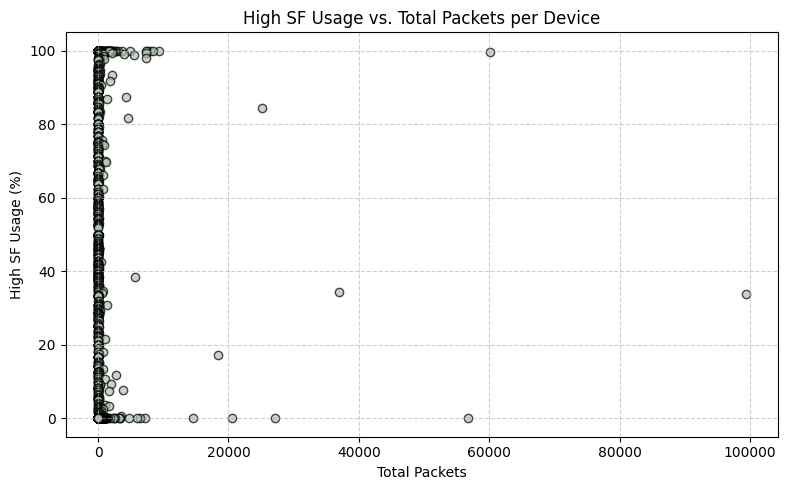

In [83]:
plt.figure(figsize=(8, 5))
plt.scatter(device_sf_summary['TotalPacketCount'],
            device_sf_summary['HighSF_Percentage'],
            color='#b0c4b1', edgecolor='black', alpha=0.7)
plt.xlabel('Total Packets')
plt.ylabel('High SF Usage (%)')
plt.title('High SF Usage vs. Total Packets per Device')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/3317343131.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



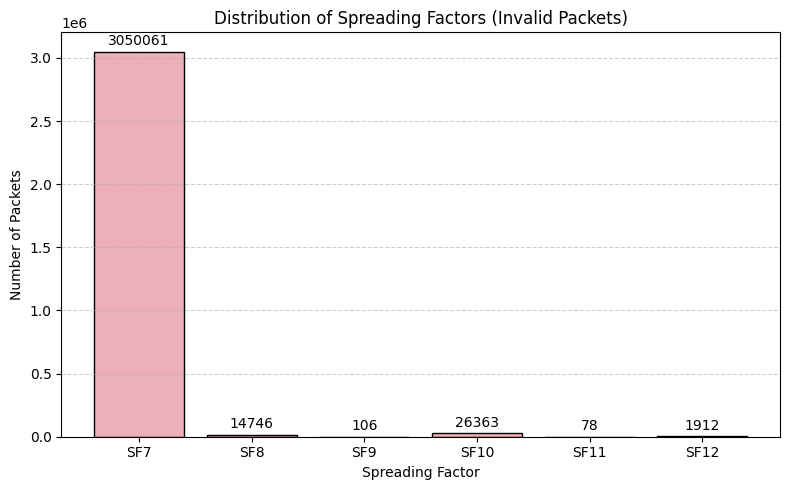

In [34]:
# Extract numeric SF
df_null_frmpayload['sf_num'] = df_null_frmpayload['datr'].str.extract(r'SF(\d+)')[0].astype(float)

# Count, sort numerically, and relabel
sf_counts_invalid = df_null_frmpayload['sf_num'].value_counts().sort_index()
sf_labels = [f'SF{int(sf)}' for sf in sf_counts_invalid.index]  # relabel x-axis

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(sf_labels, sf_counts_invalid.values, edgecolor='black', color="#edafb8")
plt.title('Distribution of Spreading Factors (Invalid Packets)')
plt.xlabel('Spreading Factor')
plt.ylabel('Number of Packets')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(sf_counts_invalid.values) * 0.01,  # Slight vertical offset
        str(int(height)),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

### Per Device Loss Ratio
Loss Ratio= Total Expected Packets / Total Lost Packets

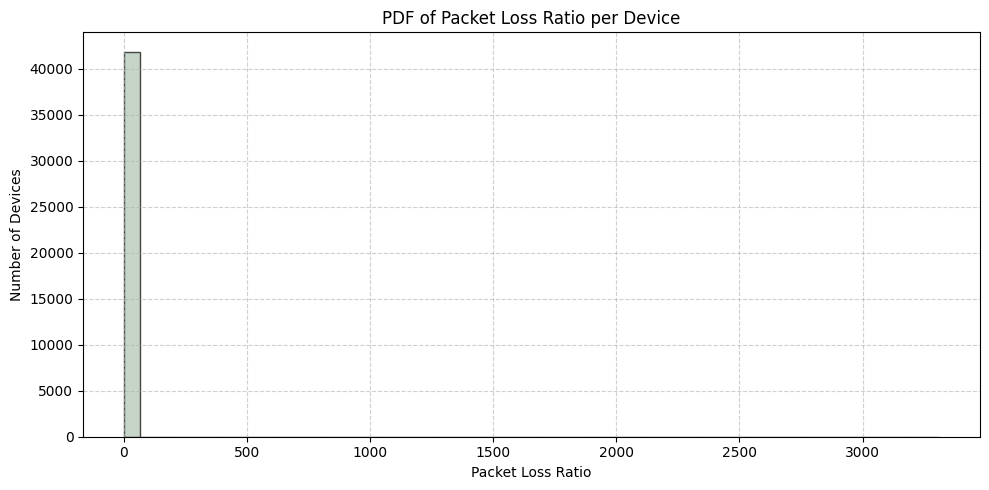

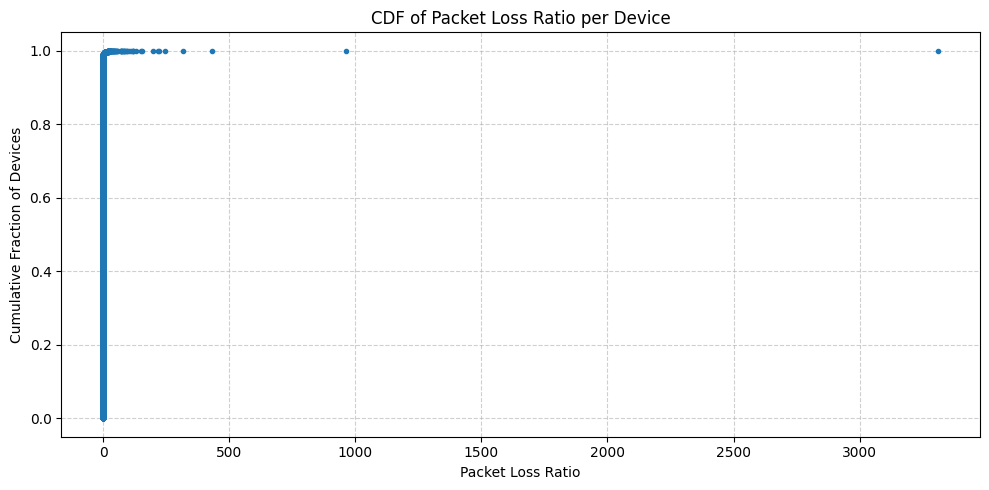

In [35]:
loss_ratios = []

# Group by DevAddr
for dev, group in df_valid_packets[['DevAddr', 'FCnt', 'tmst']].groupby('DevAddr'):
    group_sorted = group.sort_values(by='tmst')
    fcnts = group_sorted['FCnt'].values
    fcnt_diffs = np.diff(fcnts)

    # Lost packets calculation
    lost_packets = np.sum(fcnt_diffs[fcnt_diffs > 1] - 1)
    total_expected = fcnts[-1] - fcnts[0]

    if total_expected > 0:  # avoid divide by zero
        loss_ratio = lost_packets / total_expected
        loss_ratios.append(loss_ratio)

loss_ratios = np.array(loss_ratios)

# Plot PDF
plt.figure(figsize=(10, 5))
plt.hist(loss_ratios, bins=50, edgecolor='black', alpha=0.7, color='#b0c4b1')
plt.title('PDF of Packet Loss Ratio per Device')
plt.xlabel('Packet Loss Ratio')
plt.ylabel('Number of Devices')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot CDF
plt.figure(figsize=(10, 5))
sorted_ratios = np.sort(loss_ratios)
cdf = np.arange(len(sorted_ratios)) / len(sorted_ratios)
plt.plot(sorted_ratios, cdf, marker='.', linestyle='none')
plt.title('CDF of Packet Loss Ratio per Device')
plt.xlabel('Packet Loss Ratio')
plt.ylabel('Cumulative Fraction of Devices')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [75]:
# Threshold: consider loss ratio > 0.5 as high loss
high_loss_devices = sorted_ratios[sorted_ratios > 0.5]
high_loss_indices = np.where(sorted_ratios > 0.5)[0]
high_loss_devaddrs = df_valid_packets.groupby('DevAddr').filter(
    lambda g: np.diff(g.sort_values('tmst')['FCnt'].values).sum() > 0
).groupby('DevAddr').size().iloc[high_loss_indices].index.tolist()

print("Devices with high downlink loss (>50%):")
print(high_loss_devaddrs)

Devices with high downlink loss (>50%):
['006d6c26', '006d6c2d', '006d6dc7', '006d6ff8', '006d70bd', '006d70f2', '006d7179', '006d809a', '006d887a', '006d8b8c', '006d8fbe', '006d951b', '006d9a25', '006d9c93', '006d9e7b', '006d9f88', '006da984', '006dac36', '006db1d9', '006db282', '006db3c7', '006db54f', '006db697', '006db9ee', '006dbaf7', '006dbfe3', '006dc976', '006dcc8c', '006dccc5', '006dd80e', '006dd87a', '006dd903', '006ddb00', '006dddf0', '006de2d4', '006de524', '006de737', '006debc8', '006dec0d', '006decf0', '006df027', '006dfcdd', '006dfd98', '006e0636', '006e06bb', '006e08cc', '006e094a', '006e0ed9', '006e120b', '006e15ab', '006e1f15', '006e2942', '006e3434', '006e38a4', '006e3974', '006e3f56', '006e41a7', '006e45aa', '006e49aa', '006e49ff', '006e4a98', '006e4b7b', '006e557a', '006e5731', '006e59e5', '006e5d07', '006e61df', '006e61ff', '006e624c', '006e6910', '006e6aaa', '006e6c8f', '006e6d3c', '006e6e7b', '006e708a', '006e7527', '006e7738', '006e7884', '006e7905', '006e7a3a',

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/3564917509.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



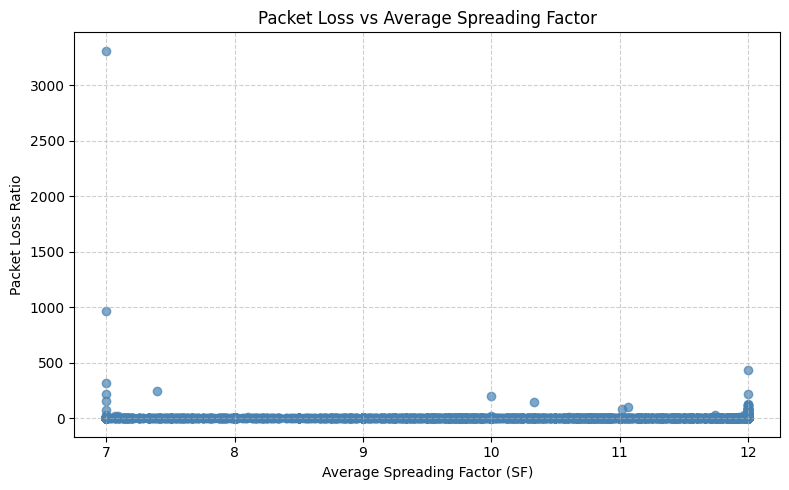

In [76]:
loss_ratios = []
loss_devaddrs = []

# Group by DevAddr
for dev, group in df_valid_packets[['DevAddr', 'FCnt', 'tmst']].groupby('DevAddr'):
    group_sorted = group.sort_values(by='tmst')
    fcnts = group_sorted['FCnt'].values
    fcnt_diffs = np.diff(fcnts)

    # Lost packets calculation
    lost_packets = np.sum(fcnt_diffs[fcnt_diffs > 1] - 1)
    total_expected = fcnts[-1] - fcnts[0]

    if total_expected > 0:
        loss_ratio = lost_packets / total_expected
        loss_ratios.append(loss_ratio)
        loss_devaddrs.append(dev)  # track matching DevAddr

# Now create the DataFrame properly
loss_sf_df = pd.DataFrame({
    'DevAddr': loss_devaddrs,
    'LossRatio': loss_ratios,
})

# Set DevAddr as index
loss_sf_df = loss_sf_df.set_index('DevAddr')

# Compute average SF per device (you can reuse this if already calculated)
df_valid_packets['sf_num'] = df_valid_packets['datr'].str.extract(r'SF(\d+)')[0].astype(int)
avg_sf_per_device = df_valid_packets.groupby('DevAddr')['sf_num'].mean()

# Join
loss_sf_df['AvgSF'] = avg_sf_per_device

# Drop any unmatched
loss_sf_df = loss_sf_df.dropna()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(loss_sf_df['AvgSF'], loss_sf_df['LossRatio'], alpha=0.7, color='#4682b4')
plt.xlabel('Average Spreading Factor (SF)')
plt.ylabel('Packet Loss Ratio')
plt.title('Packet Loss vs Average Spreading Factor')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Time analysis

In [36]:
from datetime import datetime

In [37]:
df_valid_packets['tmst_str'] = df_valid_packets['tmst'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df_null_frmpayload['tmst_str'] = df_null_frmpayload['tmst'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/3254569488.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/3254569488.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [38]:
print(df_valid_packets.tmst_str.max())
print(df_valid_packets.tmst_str.min())

2025-05-15 15:03:25
2024-10-17 18:06:47


In [39]:
print(df_null_frmpayload.tmst_str.max())
print(df_null_frmpayload.tmst_str.min())

2025-05-15 15:03:24
2024-10-17 18:06:47


/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/863306747.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/863306747.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



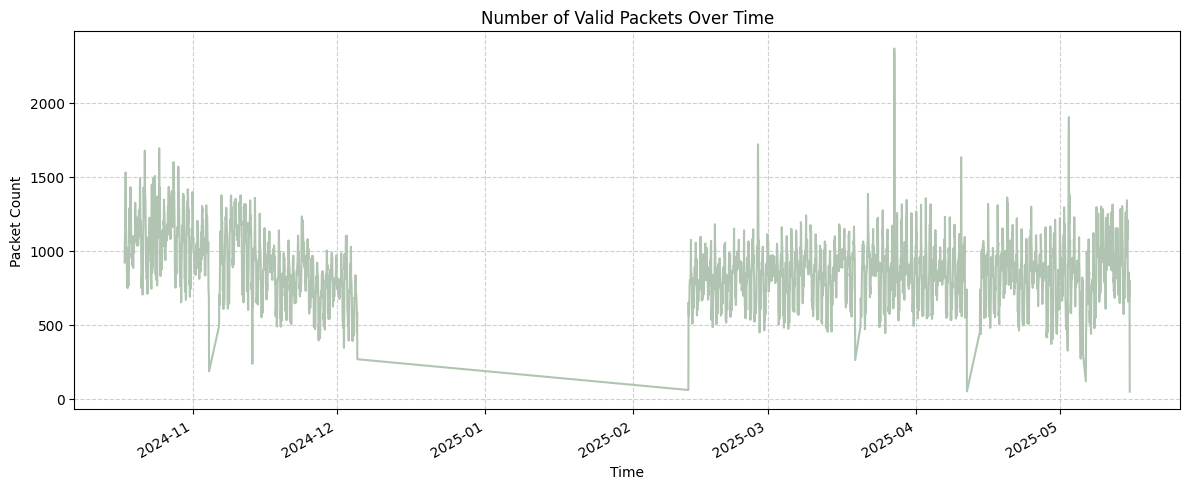

In [40]:
# Convert tmst_str back to datetime type
df_valid_packets['tmst_datetime'] = pd.to_datetime(df_valid_packets['tmst_str'], format='%Y-%m-%d %H:%M:%S')

# Get hourly info
df_valid_packets['time_bin'] = df_valid_packets['tmst_datetime'].dt.floor('1H')  # group by hour

# Count packets per time bin
packet_counts = df_valid_packets.groupby('time_bin').size()

plt.figure(figsize=(12, 5))
packet_counts.plot(kind='line', color="#b0c4b1")
plt.title('Number of Valid Packets Over Time')
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/2410637500.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/2410637500.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



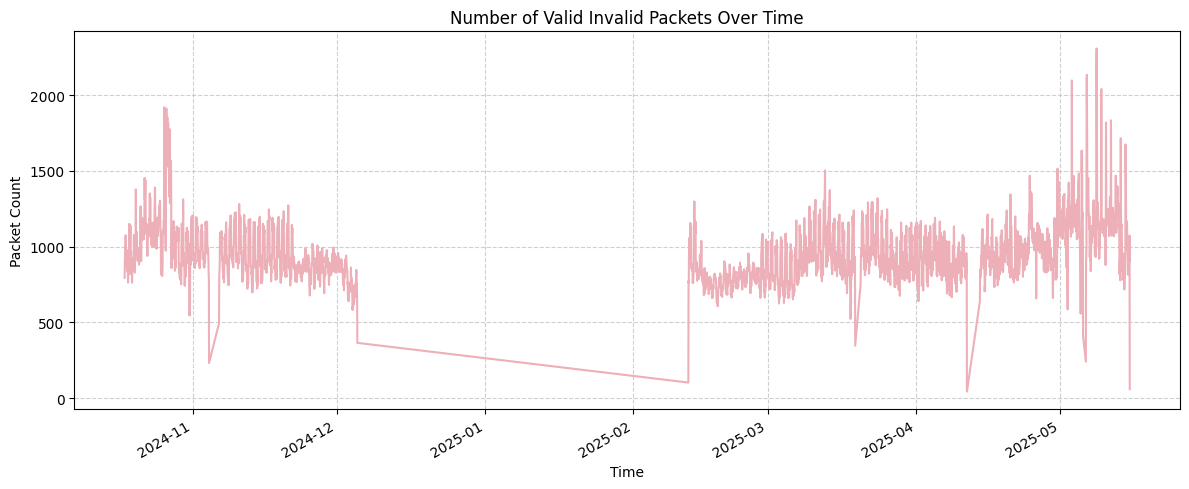

In [41]:
# Convert tmst_str back to datetime type
df_null_frmpayload['tmst_datetime'] = pd.to_datetime(df_null_frmpayload['tmst_str'], format='%Y-%m-%d %H:%M:%S')

# Get hourly info
df_null_frmpayload['time_bin'] = df_null_frmpayload['tmst_datetime'].dt.floor('1H')  # group by hour

# Count packets per time bin
packet_counts_invalid = df_null_frmpayload.groupby('time_bin').size()

plt.figure(figsize=(12, 5))
packet_counts_invalid.plot(kind='line', color="#edafb8")
plt.title('Number of Valid Invalid Packets Over Time')
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [77]:
# Extract just the date from the timestamp
df_valid_packets['date'] = df_valid_packets['tmst_datetime'].dt.date

# Count packets per date
daily_counts = df_valid_packets.groupby('date').size()

# Get top 10 dates
top_10_dates = daily_counts.sort_values(ascending=False).head(10)

top_10_dates

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/3996512085.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



date
2024-10-27    30209
2024-11-10    27914
2024-10-26    27744
2024-10-20    27605
2024-11-09    27369
2024-10-24    26549
2024-10-21    26360
2024-10-28    26333
2024-10-25    26171
2024-10-30    25890
dtype: int64

In [78]:
# Devices active on April 2
active_apr2 = df_valid_packets[df_valid_packets['date'] == pd.to_datetime('2025-04-02').date()]
print("Unique devices on April 2:", active_apr2['DevAddr'].nunique())
print("Top devices by packet count on April 2:")
print(active_apr2['DevAddr'].value_counts().head())

Unique devices on April 2: 1737
Top devices by packet count on April 2:
DevAddr
f3181dbe    1024
00000000     425
000000d8     373
00000101     226
00818958     183
Name: count, dtype: int64


In [79]:
# Count packets per SF
active_apr2['sf_num'] = active_apr2['datr'].str.extract(r'SF(\d+)')[0].astype(int)
sf_counts_apr2 = active_apr2['sf_num'].value_counts().sort_index()

print("SF distribution on April 2:")
print(sf_counts_apr2)

SF distribution on April 2:
sf_num
7     14730
8       425
9       421
10      695
11      598
12     2514
Name: count, dtype: int64


/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/3766170141.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Activity Counts per Device

Top 10 most active devices:
DevAddr
f3181dbe    99371
00000000    60180
c90c9220    56817
000000d8    36993
c80c9220    27094
01010101    25162
2b0404ee    20570
015eb0df    18420
60000000    14546
e011be04     9406
Name: count, dtype: int64


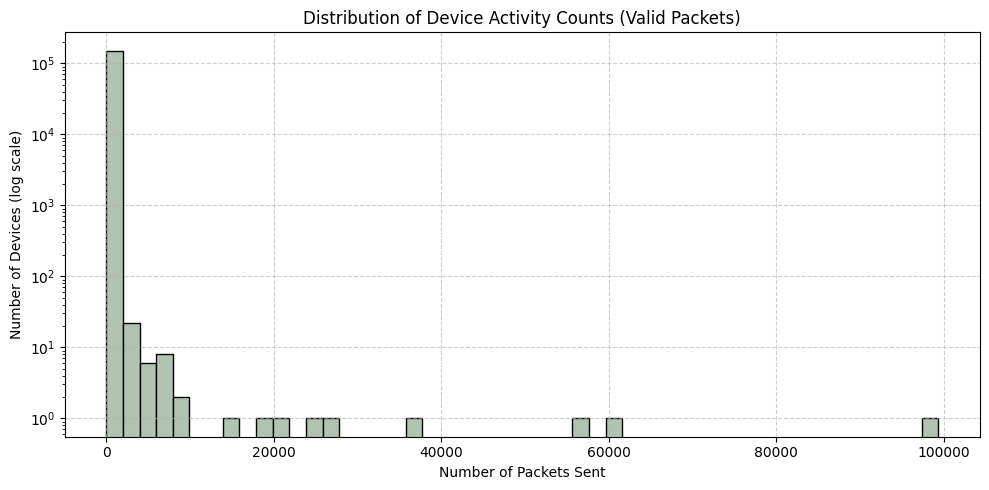

In [42]:
# Count total packets per device (valid only)
device_activity_counts = df_valid_packets['DevAddr'].value_counts()

print("Top 10 most active devices:")
print(device_activity_counts.head(10))

# Plot histogram of device activity counts
plt.figure(figsize=(10, 5))
plt.hist(device_activity_counts, bins=50, color='#b0c4b1', edgecolor='black', log=True)
plt.title('Distribution of Device Activity Counts (Valid Packets)')
plt.xlabel('Number of Packets Sent')
plt.ylabel('Number of Devices (log scale)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

- Most devices sent very few packets (1–100) — typical for low-traffic or rarely used devices.
- A small group of devices sent tens of thousands of packets — these are the super active devices or core sensors.
- The log scale shows a heavy tail distribution — a few devices dominate traffic.

Top 10 most active devices (invalid packets):
DevAddr
7304526b    169259
2b0404ee    156055
37061af8    134150
c90c9220    132982
050cc535    117366
050c4bfc    117340
050c68fc    117304
050ce3c6    117244
050cd0c6    117164
050cd3c6    116856
Name: count, dtype: int64


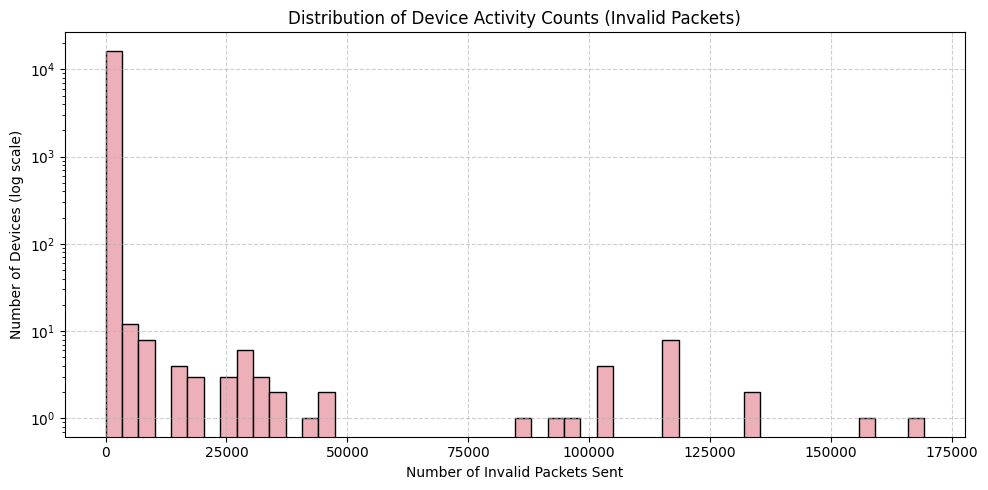

In [43]:
# Count total invalid packets per device
device_activity_counts_invalid = df_null_frmpayload['DevAddr'].value_counts()

print("Top 10 most active devices (invalid packets):")
print(device_activity_counts_invalid.head(10))

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(device_activity_counts_invalid, bins=50, color='#edafb8', edgecolor='black', log=True)
plt.title('Distribution of Device Activity Counts (Invalid Packets)')
plt.xlabel('Number of Invalid Packets Sent')
plt.ylabel('Number of Devices (log scale)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The majority of devices send very few invalid packets — again, typical for low-traffic or well-configured devices.
- A notable group of devices (small but visible tail) sends tens of thousands of invalid packets — possible misconfigured or error-prone devices.

- The heavy-tailed distribution in the log-scale confirms:

Most devices are fine

A small group of devices are error sources — potential maintenance targets!

### Hourly Activity of Top 5 Valid Devices

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/1418227593.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



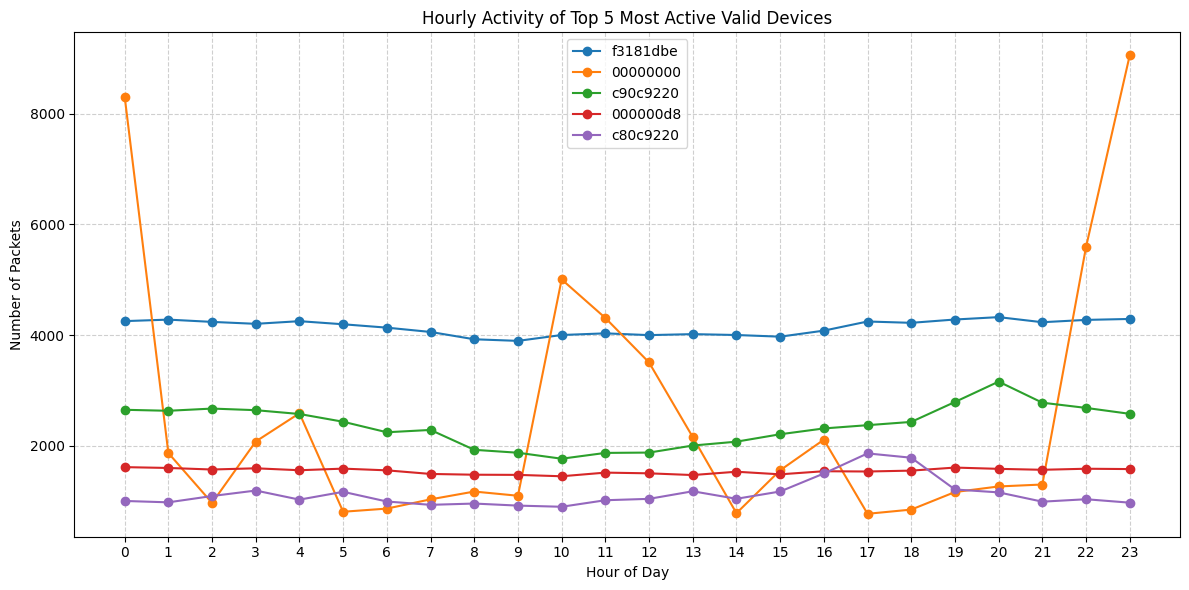

In [44]:
# Identify top 5 most active valid devices
top_5_valid_devices = device_activity_counts.head(5).index.tolist()

# Extract hour of day from timestamps (if not already done)
df_valid_packets['hour'] = pd.to_datetime(df_valid_packets['tmst'], unit='s').dt.hour

# Plot hourly activity for each of the top 5 valid devices
plt.figure(figsize=(12, 6))

for dev in top_5_valid_devices:
    hourly_counts = df_valid_packets[df_valid_packets['DevAddr'] == dev]['hour'].value_counts().sort_index()
    plt.plot(hourly_counts.index, hourly_counts.values, marker='o', label=str(dev))

plt.title('Hourly Activity of Top 5 Most Active Valid Devices')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Packets')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


✅ Device f3181dbe (blue line):

Has very steady activity throughout the day (~4,000 packets/hour).

No significant peaks or dips — likely a critical, always-on device.

✅ Device 00000000 (orange line):

Large spike at midnight (8,000+ packets!).

Another spike around 10–11 AM and late evening (10–11 PM).

Indicates burst behavior — maybe a mobile device or periodic reporting sensor.

✅ Device c90c9220 (green line):

More gradual activity during the day, slight peak in the evening — maybe environment or usage-based.

✅ Devices 000000d8 and c80c9220 (red/purple lines):

Lower volume, but steady activity without big hourly fluctuations.

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/3078874334.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



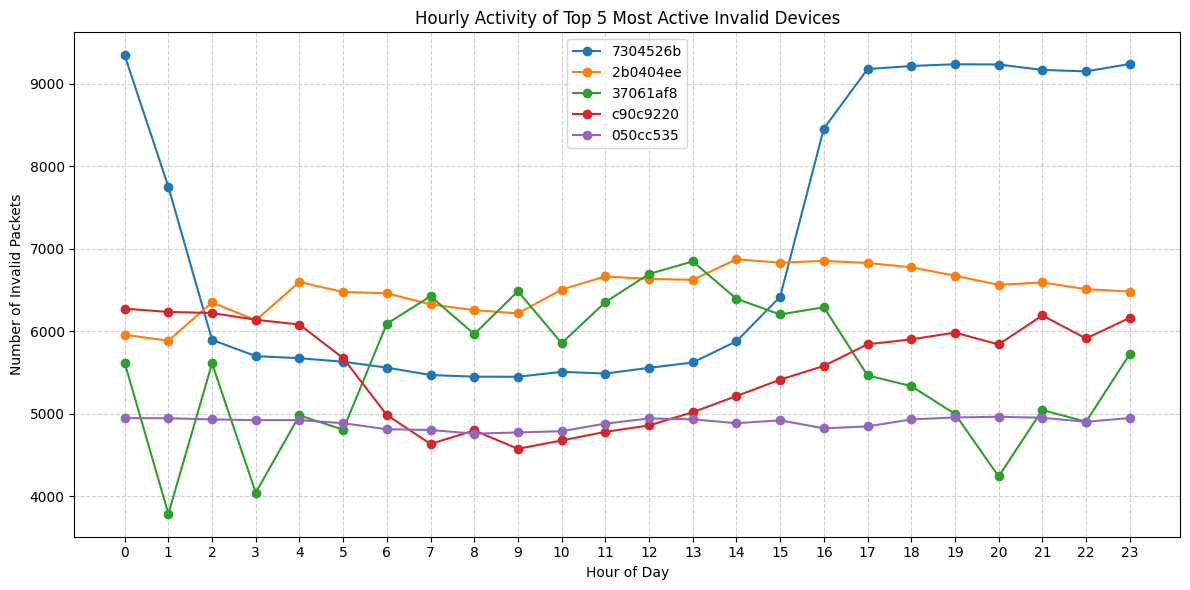

In [45]:
import matplotlib.pyplot as plt

# Identify top 5 most active invalid devices
top_5_invalid_devices = device_activity_counts_invalid.head(5).index.tolist()

# Extract hour of day for invalid packets
df_null_frmpayload['hour'] = pd.to_datetime(df_null_frmpayload['tmst'], unit='s').dt.hour

# Plot hourly activity for each top invalid device
plt.figure(figsize=(12, 6))

for dev in top_5_invalid_devices:
    hourly_counts_invalid = df_null_frmpayload[df_null_frmpayload['DevAddr'] == dev]['hour'].value_counts().sort_index()
    plt.plot(hourly_counts_invalid.index, hourly_counts_invalid.values, marker='o', label=str(dev))

plt.title('Hourly Activity of Top 5 Most Active Invalid Devices')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Invalid Packets')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


- Most of these invalid-heavy devices have a steady baseline activity (~5,000–6,000 invalid packets/hour) across the whole day.
- Device 7304526b (blue line) has:

- - A sharp drop after midnight but increases again after 3 PM.

- - Possible periodic bursts of invalid traffic — maybe linked to an error condition or misconfigured transmission window.

- Other devices like 2b0404ee and c90c9220 (orange/red lines) show steady invalid traffic without clear hourly variations — likely consistently faulty or misconfigured.

#### Daily Activity of Top 5 Valid Devices

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/2545001424.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



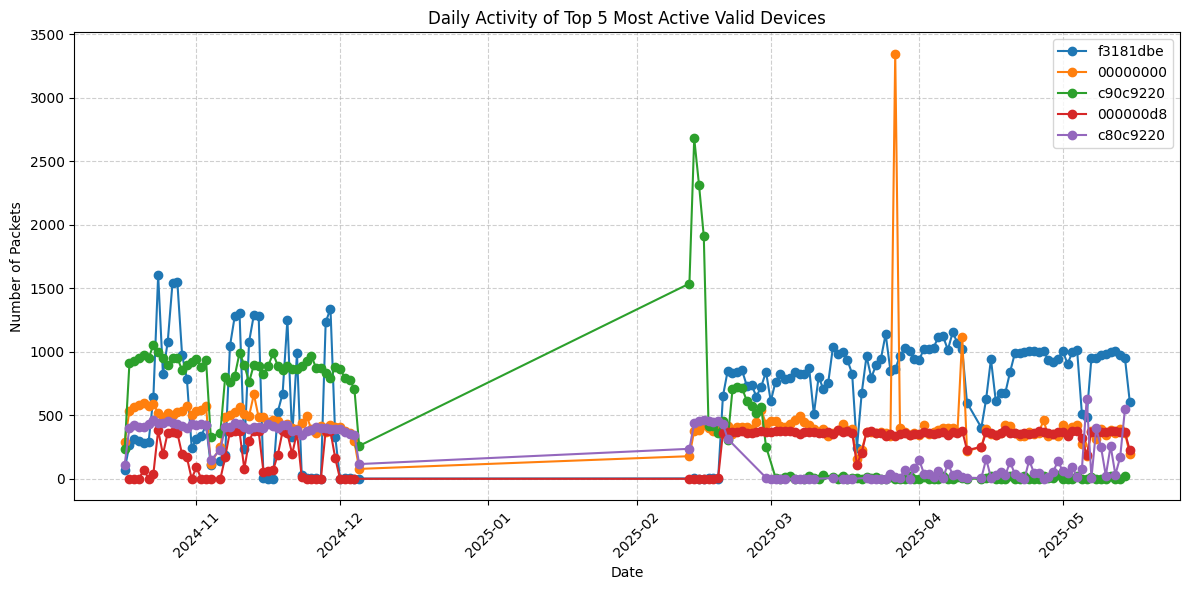

In [46]:
import matplotlib.pyplot as plt

# Extract date from timestamp for valid packets
df_valid_packets['date'] = pd.to_datetime(df_valid_packets['tmst'], unit='s').dt.date

# Identify top 5 valid devices
top_5_valid_devices = device_activity_counts.head(5).index.tolist()

# Plot daily activity for each top valid device
plt.figure(figsize=(12, 6))

for dev in top_5_valid_devices:
    daily_counts = df_valid_packets[df_valid_packets['DevAddr'] == dev]['date'].value_counts().sort_index()
    plt.plot(daily_counts.index, daily_counts.values, marker='o', label=str(dev))

plt.title('Daily Activity of Top 5 Most Active Valid Devices')
plt.xlabel('Date')
plt.ylabel('Number of Packets')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


✅ Device f3181dbe (blue):

Shows consistent daily activity throughout the entire period.

Small day-to-day fluctuations, but generally steady — likely a fixed, always-on sensor.

✅ Device 00000000 (orange):

Mostly steady, but has a huge spike in April 2025 (over 3,000 packets) — might be a maintenance event or reconfiguration burst.

✅ Device c90c9220 (green):

Significant gaps in activity — periods of inactivity, then sudden bursts (like in February 2025).

Could indicate periodic mobility (like a mobile asset) or network coverage fluctuations.

✅ Devices 000000d8 and c80c9220 (red/purple):

Lower overall volumes, but very steady — classic of low-traffic, static sensors.

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/3993858001.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



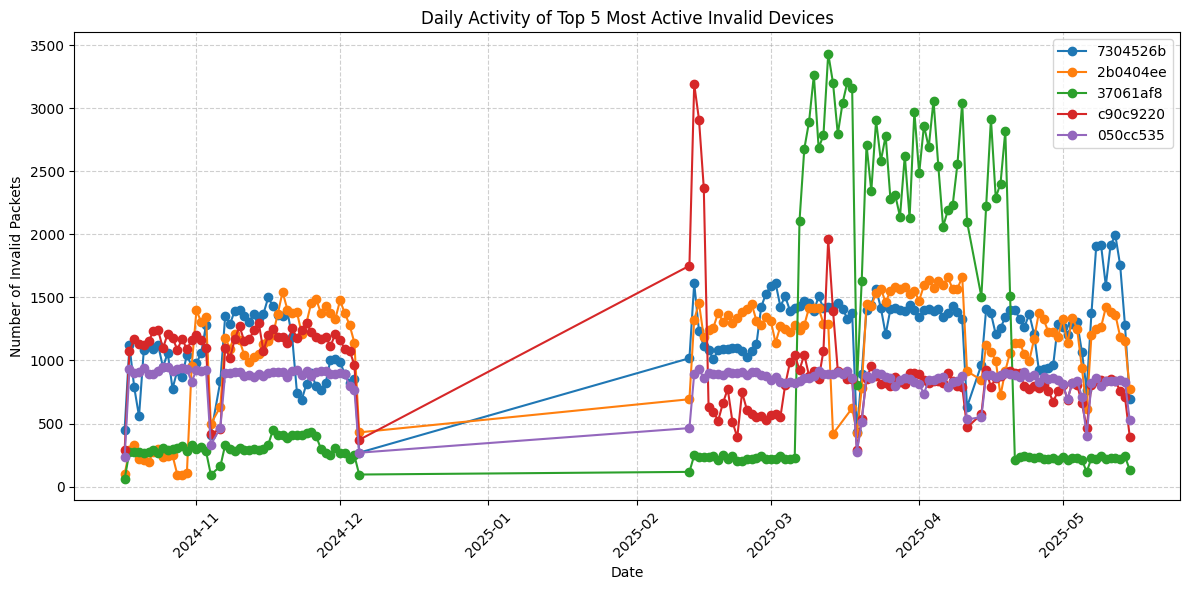

In [47]:
import matplotlib.pyplot as plt

# Extract date from timestamp for invalid packets
df_null_frmpayload['date'] = pd.to_datetime(df_null_frmpayload['tmst'], unit='s').dt.date

# Identify top 5 invalid devices
top_5_invalid_devices = device_activity_counts_invalid.head(5).index.tolist()

# Plot daily activity for each top invalid device
plt.figure(figsize=(12, 6))

for dev in top_5_invalid_devices:
    daily_counts_invalid = df_null_frmpayload[df_null_frmpayload['DevAddr'] == dev]['date'].value_counts().sort_index()
    plt.plot(daily_counts_invalid.index, daily_counts_invalid.values, marker='o', label=str(dev))

plt.title('Daily Activity of Top 5 Most Active Invalid Devices')
plt.xlabel('Date')
plt.ylabel('Number of Invalid Packets')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


✅ Overall Activity

Most devices have persistent invalid activity day after day — some baseline level of errors.

Clear maintenance windows (visible gaps or sudden changes in pattern).

✅ Devices with Bursts / Spikes

c90c9220 (red): Sharp spikes of invalid packets — suggests possible reconfiguration or periodic faults.

37061af8 (green): Fluctuations with major increases — likely mobility or repeated link adaptation failures.

✅ Steady Invalid Activity

Devices like 2b0404ee (orange) and 050cc535 (purple): More stable daily invalid traffic — might indicate systematic misconfiguration rather than dynamic failures.



### RSSI/SNR Stats per Device


    DevAddr   rssi_mean   rssi_std   snr_mean   snr_std
0  00000000 -121.306913   7.161660 -11.744010  4.973490
1  00000001 -123.117897   6.727198 -12.241052  5.375674
2  00000002 -129.016043   3.841589 -14.520856  2.774683
3  00000003 -124.651007   5.742123 -11.126846  4.880236
4  00000004 -120.204878  11.369764  -8.252195  8.442386


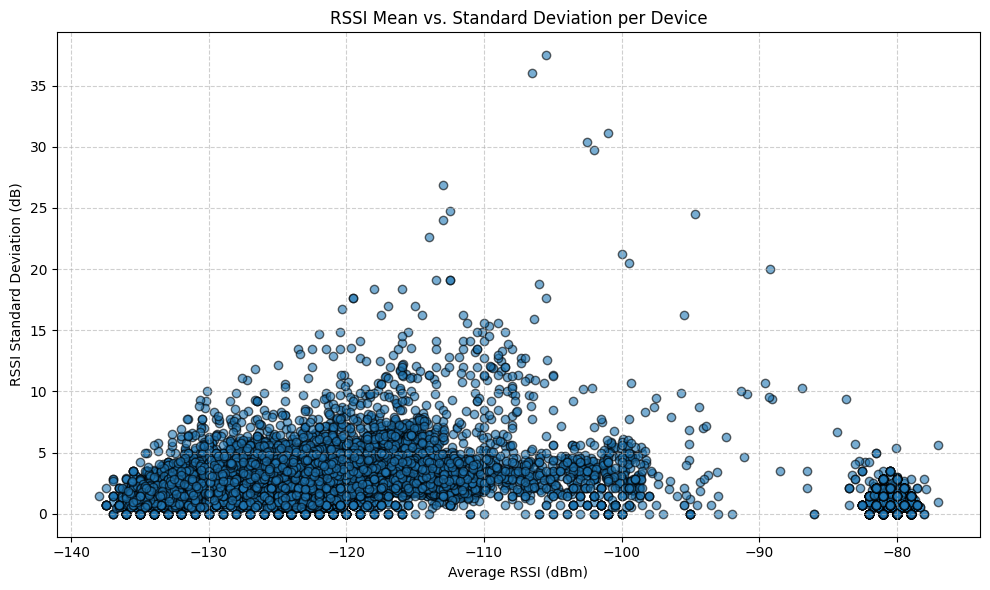

In [58]:
# Calculate RSSI and SNR average and variance per device
rssi_snr_stats = df_valid_packets.groupby('DevAddr').agg({
    'rssi': ['mean', 'std'],
    'lsnr': ['mean', 'std']
}).reset_index()

# Rename columns for clarity
rssi_snr_stats.columns = ['DevAddr', 'rssi_mean', 'rssi_std', 'snr_mean', 'snr_std']

# Show top rows
print(rssi_snr_stats.head())

# Plot RSSI mean vs. std scatter to see stability
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(rssi_snr_stats['rssi_mean'], rssi_snr_stats['rssi_std'], alpha=0.6, edgecolors='black')
plt.title('RSSI Mean vs. Standard Deviation per Device')
plt.xlabel('Average RSSI (dBm)')
plt.ylabel('RSSI Standard Deviation (dB)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


-  Most devices cluster between -140 dBm and -100 dBm average RSSI — typical for LoRaWAN’s long-range, low-power characteristics.
-  RSSI variance (standard deviation) mostly below 10 dB, suggesting relatively stable links for the majority of devices.
-  A smaller group of outlier devices has RSSI variance above 20 dB — these are likely mobile or in dynamic environments.

    DevAddr   rssi_mean  rssi_std  snr_mean   snr_std
0  00000355 -105.627168  3.333774  3.219509  5.154612
1  00000356 -105.458101  4.617291  2.915531  5.201620
2  00000358 -117.077790  3.782444 -5.275536  2.769220
3  0000035f -110.331149  3.476113  0.629482  3.630576
4  00000360  -95.540616  4.418971  7.459010  4.921367


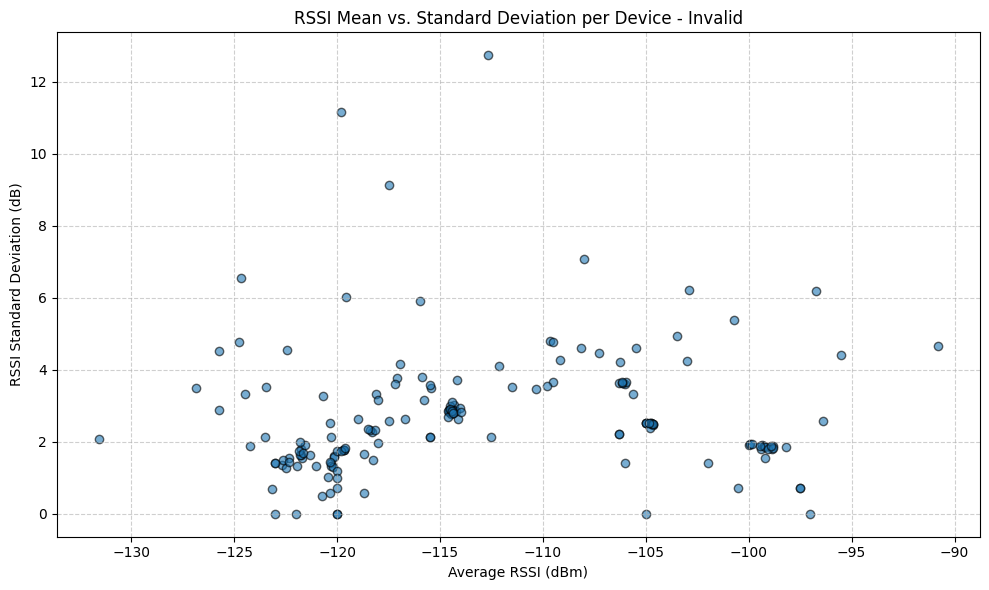

In [57]:
# Calculate RSSI and SNR average and variance per device
rssi_snr_stats_invalid = df_null_frmpayload.groupby('DevAddr').agg({
    'rssi': ['mean', 'std'],
    'lsnr': ['mean', 'std']
}).reset_index()

# Rename columns for clarity
rssi_snr_stats_invalid.columns = ['DevAddr', 'rssi_mean', 'rssi_std', 'snr_mean', 'snr_std']

# Show top rows
print(rssi_snr_stats_invalid.head())

# Plot RSSI mean vs. std scatter to see stability
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(rssi_snr_stats_invalid['rssi_mean'], rssi_snr_stats_invalid['rssi_std'], alpha=0.6, edgecolors='black')
plt.title('RSSI Mean vs. Standard Deviation per Device - Invalid')
plt.xlabel('Average RSSI (dBm)')
plt.ylabel('RSSI Standard Deviation (dB)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


- Most devices have an average RSSI between -130 dBm and -100 dBm — typical of weak signals.
- RSSI variance (std) mostly stays below 5 dB — suggests that for most devices, even invalid traffic happens in relatively stable link conditions.

- There are a few outliers:

Devices with std deviation above 10 dB — indicates very dynamic environments or movement.

For example, some devices around -120 dBm show up to 12 dB variance — might be mobile sensors or experiencing interference.

#### List Most Unstable Devices

In [63]:
# Sort devices by RSSI standard deviation (descending)
most_unstable_devices = rssi_snr_stats.sort_values(by='rssi_std', ascending=False).head(10)

print("Valid - Top 10 most unstable devices based on RSSI variance:")
print(most_unstable_devices[['DevAddr', 'rssi_mean', 'rssi_std', 'snr_mean', 'snr_std']])

Valid - Top 10 most unstable devices based on RSSI variance:
         DevAddr   rssi_mean   rssi_std   snr_mean    snr_std
147994  fc256e00 -105.500000  37.476659  -4.500000  17.677670
149290  fc4bc000 -106.500000  36.062446  -4.250000  18.455487
149128  fc409700 -101.000000  31.112698  -3.500000  16.970563
143889  fc089100 -102.500000  30.405592  -3.100000  15.414928
149069  fc3e0b00 -102.000000  29.698485  -1.100000  15.414928
56538   1e88ad54 -113.000000  26.870058  -5.750000  14.212846
92393   80002900 -112.500000  24.748737  -5.350000  15.768481
143216  fc058300  -94.666667  24.542480   2.166667  12.112941
10406   0072cc1a -113.000000  24.041631 -19.300000   0.707107
90871   7c3d0200 -114.000000  22.627417  -5.000000  14.566400


- These devices have very high RSSI variance (22 dB to 37 dB!) — indicating highly dynamic links.

- Their average RSSI values range from -94 dBm to -114 dBm — typical for weak links, but not the absolute worst.

- Their SNR standard deviation is also very high (often > 15 dB), suggesting fast-changing environments or significant mobility.

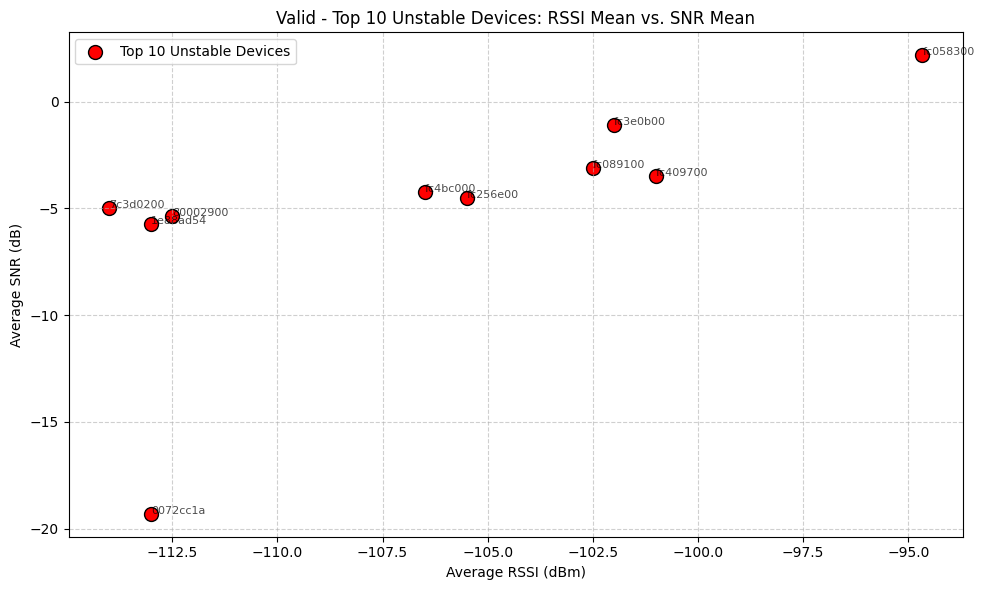

In [64]:
# Top 10 unstable devices (already calculated)
unstable_devices = most_unstable_devices.copy()

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(unstable_devices['rssi_mean'], unstable_devices['snr_mean'],
            color='red', edgecolor='black', s=100, label='Top 10 Unstable Devices')

# Label points with DevAddr
for i, row in unstable_devices.iterrows():
    plt.text(row['rssi_mean'], row['snr_mean'], row['DevAddr'], fontsize=8, alpha=0.7)

plt.title('Valid - Top 10 Unstable Devices: RSSI Mean vs. SNR Mean')
plt.xlabel('Average RSSI (dBm)')
plt.ylabel('Average SNR (dB)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [67]:
# Sort devices by RSSI standard deviation (descending)
most_unstable_devices_invalid = rssi_snr_stats_invalid.sort_values(by='rssi_std', ascending=False).head(10)

print("Invalid - Top 10 most unstable devices based on RSSI variance:")
print(most_unstable_devices_invalid[['DevAddr', 'rssi_mean', 'rssi_std', 'snr_mean', 'snr_std']])

Invalid - Top 10 most unstable devices based on RSSI variance:
        DevAddr   rssi_mean   rssi_std   snr_mean   snr_std
5058   520a1dd8 -112.666667  12.741010  -3.933333  8.031397
16     0000154d -119.800000  11.166915  -6.200000  9.471008
12576  c1cb6002 -117.500000   9.146948 -11.425000  2.174665
11977  b9a977d8 -108.000000   7.071068   3.500000  7.495332
15517  f000004e -124.666667   6.551911 -14.837500  2.551183
7575   7d04526b -102.882353   6.223768   1.747059  4.344698
5250   55499926  -96.750000   6.184658   6.725000  2.861672
13466  d00006b2 -119.541667   6.023282 -11.315278  2.787935
16210  fc0002ff -115.948276   5.922463  -3.905172  1.902303
7003   7304526b -100.716500   5.374406   2.599319  3.886158


- These devices have very high RSSI variance (up to 12.7 dB!), meaning their signal strength is highly dynamic.
- Devices like 520a1dd8 (rssi_std: 12.7) and 0000154d (11.1) are top unstable — they might be mobile sensors or in dynamic environments (interference, moving machinery, vehicles).

- RSSI Mean Context:

Some have very low average RSSI (like -124 dBm for f000004e), suggesting they’re far from the gateway or heavily obstructed.

Others have better RSSI (like 55499926 at -96 dBm) but still show big fluctuations.

- SNR Variance Context:

Some devices also have high SNR variance (like 0000154d with snr_std 9.47) — signals are not only weak but also noisy.

Others (like c1cb6002) have high RSSI variance but low SNR variance — suggests link instability is purely distance-related rather than noise.

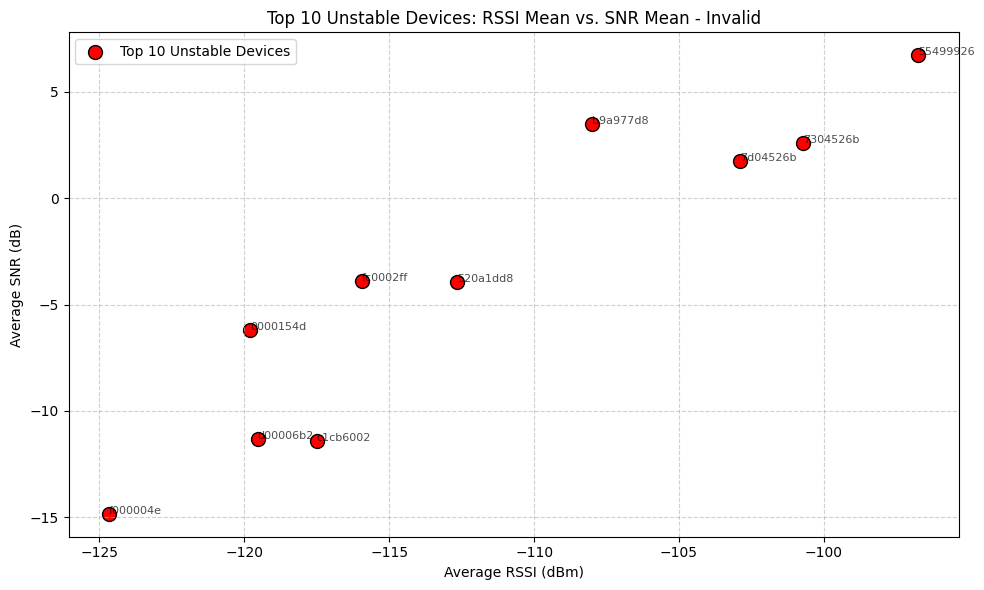

In [69]:
# Top 10 unstable devices (already calculated)
unstable_devices_invalid = most_unstable_devices_invalid.copy()

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(unstable_devices_invalid['rssi_mean'], unstable_devices_invalid['snr_mean'],
            color='red', edgecolor='black', s=100, label='Top 10 Unstable Devices')

# Label points with DevAddr
for i, row in unstable_devices_invalid.iterrows():
    plt.text(row['rssi_mean'], row['snr_mean'], row['DevAddr'], fontsize=8, alpha=0.7)

plt.title('Top 10 Unstable Devices: RSSI Mean vs. SNR Mean - Invalid')
plt.xlabel('Average RSSI (dBm)')
plt.ylabel('Average SNR (dB)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


- Most devices have average RSSI around -125 to -100 dBm — typical for weak links in a LoRaWAN deployment.
- The majority of SNR values are negative (as expected for these links), but:

A few devices (like 5499926, 9a977d8) have positive SNRs — indicating stronger link quality even with weaker RSSI.

Devices like 00004e have both weak RSSI and very low SNR — likely worst performance.

- Spread of points:

Devices like 9a977d8, 5499926: outliers with surprisingly clean signals despite low RSSI.

Devices at the bottom left: consistently bad links (weak signal and noisy environment).

### Spreading Factor (SF) Usage Patterns

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/2380786556.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



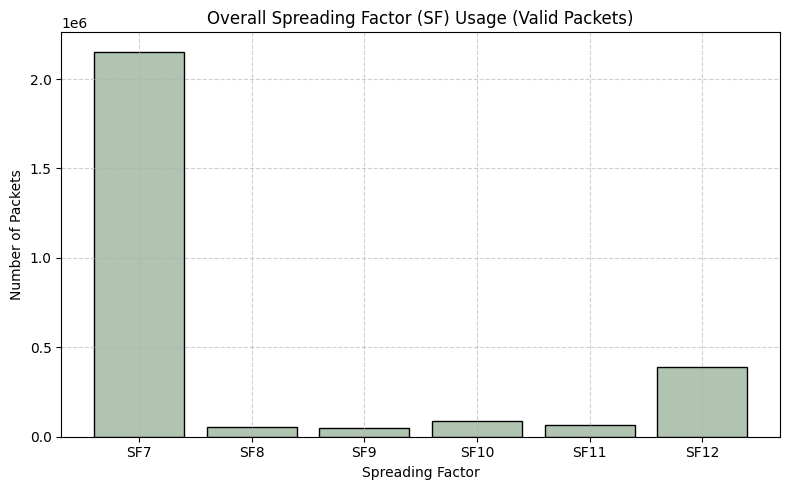

Spreading Factor usage counts:
sf_num
7.0     2153305
8.0       51643
9.0       50621
10.0      90585
11.0      65076
12.0     391483
Name: count, dtype: int64


In [70]:
import matplotlib.pyplot as plt

# Extract numeric SF (if not already done)
df_valid_packets['sf_num'] = df_valid_packets['datr'].str.extract(r'SF(\d+)')[0].astype(float)

# Count SF usage
sf_counts_valid = df_valid_packets['sf_num'].value_counts().sort_index()

# Relabel for better plots
sf_labels = [f'SF{int(sf)}' for sf in sf_counts_valid.index]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(sf_labels, sf_counts_valid.values, color='#b0c4b1', edgecolor='black')
plt.title('Overall Spreading Factor (SF) Usage (Valid Packets)')
plt.xlabel('Spreading Factor')
plt.ylabel('Number of Packets')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Spreading Factor usage counts:")
print(sf_counts_valid)


- SF7 dominates (over 2 million packets!) — most devices are close enough to the gateway to use low SF (shorter range, higher data rate).
- SF12 is also significant (about 400k packets) — suggesting some long-range or weaker link devices.
- Other SFs (8–11) are much less used — typical in LoRaWAN deployments, as SF7 is preferred for high data rate and SF12 for long-range fallback.

Per-Device SF Variance

    DevAddr  unique_sf_count
0  00000000                6
1  00000001                6
2  00000002                1
3  00000003                1
4  00000004                1


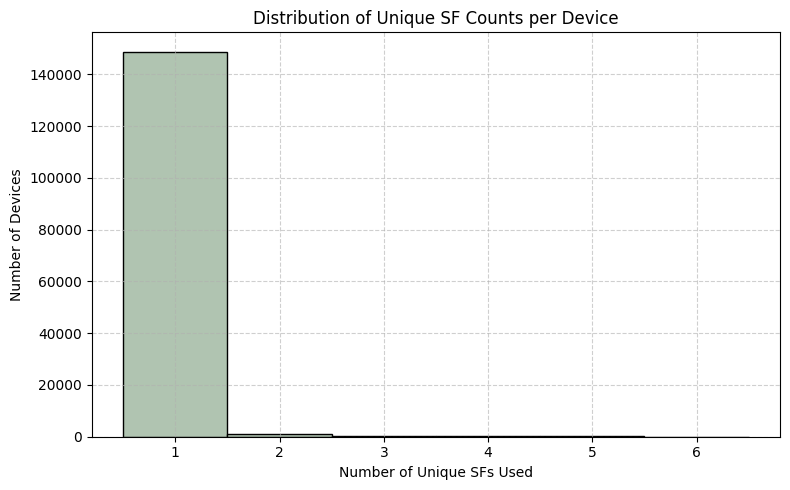

In [71]:
# Count unique SFs used by each device
sf_variance_per_device = df_valid_packets.groupby('DevAddr')['sf_num'].nunique().reset_index()
sf_variance_per_device.columns = ['DevAddr', 'unique_sf_count']

# Show top rows
print(sf_variance_per_device.head())

# Plot distribution of unique SF counts
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(sf_variance_per_device['unique_sf_count'], bins=range(1, sf_variance_per_device['unique_sf_count'].max()+2), color='#b0c4b1', edgecolor='black', align='left')
plt.title('Distribution of Unique SF Counts per Device')
plt.xlabel('Number of Unique SFs Used')
plt.ylabel('Number of Devices')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


- The vast majority of devices (~150,000) only use 1 SF — typical for static or very stable devices in your LoRaWAN network.
- Only a tiny number of devices switch between 2 or more SFs — these are the dynamic or mobile devices or those in variable coverage.

List Devices with Most SF Switching

In [72]:
# Filter for devices using more than 1 SF
dynamic_sf_devices = sf_variance_per_device[sf_variance_per_device['unique_sf_count'] > 1]

# Sort by number of unique SFs used (descending)
dynamic_sf_devices_sorted = dynamic_sf_devices.sort_values(by='unique_sf_count', ascending=False)

print(f"Number of devices that switch SFs: {len(dynamic_sf_devices_sorted)}")
print("Top devices with most SF variations:")
print(dynamic_sf_devices_sorted.head(10))


Number of devices that switch SFs: 1853
Top devices with most SF variations:
         DevAddr  unique_sf_count
0       00000000                6
43079   01db7c8c                6
8163    00594f00                6
17817   00c5811d                6
8380    005ba1fa                6
8394    005bdc8e                6
56978   1fa414de                6
131478  e0108904                6
51712   11223344                6
131502  e010a8ec                6


- 1853 devices in total switch SFs — a small but significant group (~1% of all devices).
- These devices have up to 6 unique SFs — meaning they dynamically adapt from SF7 to SF12 depending on link conditions.

- Top dynamic devices (like 00000000, 01db7c8c, 00594f00, etc.) are very versatile in link adaptation — likely:

Mobile sensors (asset tracking, vehicle monitoring).

Devices in variable environments (factories, urban clutter).

/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_38731/1071546244.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



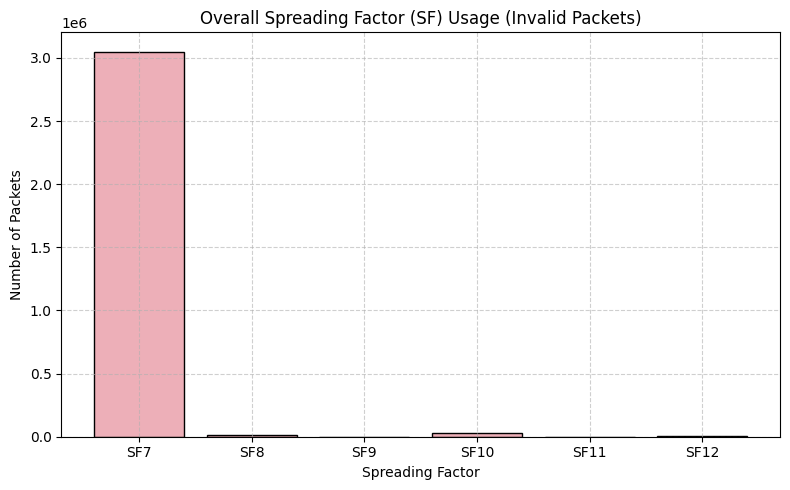

Spreading Factor usage counts:
sf_num
7.0     3050061
8.0       14746
9.0         106
10.0      26363
11.0         78
12.0       1912
Name: count, dtype: int64


In [73]:
import matplotlib.pyplot as plt

# Extract numeric SF (if not already done)
df_null_frmpayload['sf_num'] = df_null_frmpayload['datr'].str.extract(r'SF(\d+)')[0].astype(float)

# Count SF usage
sf_counts_invalid = df_null_frmpayload['sf_num'].value_counts().sort_index()

# Relabel for better plots
sf_labels = [f'SF{int(sf)}' for sf in sf_counts_invalid.index]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(sf_labels, sf_counts_invalid.values, color='#edafb8', edgecolor='black')
plt.title('Overall Spreading Factor (SF) Usage (Invalid Packets)')
plt.xlabel('Spreading Factor')
plt.ylabel('Number of Packets')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Spreading Factor usage counts:")
print(sf_counts_invalid)


- SF7 dominates by a huge margin (over 3 million invalid packets!).
- Other SFs (like SF8, SF9, SF10, SF11, SF12) have negligible invalid traffic.
- The massive gap suggests that most invalid traffic occurs when using SF7.